In [9]:
from osgeo import gdal
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
from anytree import Node, RenderTree, NodeMixin
from anytree.exporter import DotExporter
from anytree.dotexport import RenderTreeGraph
from multiprocess import Process, Queue
from numba import jit

In [10]:
#Возьмем тренировочные данные
#328930.0184,330487.6492,4200807.9496,4202455.4870 [EPSG:32614]
#335585.1422,336057.3203,4210112.1965,4210481.0856 [EPSG:32614]
#328167.3988,328411.1949,4199804.3245,4199922.9279 [EPSG:32614]
#344778.9990,345583.0668,4193951.2446,4194700.3334 [EPSG:32614]
#320457.2751,321708.0471,4202522.4693,4203354.0266 [EPSG:32614]

#329449.6019,329970.1722,4202967.8065,4203356.5869 [EPSG:32614]
#315166.2769,324971.4494,4198424.1092,4205136.6108 [EPSG:32614]
#346388.6887,348881.2188,4193749.9146,4195567.9954 [EPSG:32614]
#346371.9777,348285.7235,4193896.9826,4195565.2967 [EPSG:32614]

In [11]:
print(('голая земля', 'кукуруза', 'сорго', 'сорт сорго', 'овес', 'рожь', 'люцерна', 'картофель', 'сено', 'пастбища', 'болото', 'цветы', 'сорт овса', 'сорт кукурузы'))

('голая земля', 'кукуруза', 'сорго', 'сорт сорго', 'овес', 'рожь', 'люцерна', 'картофель', 'сено', 'пастбища', 'болото', 'цветы', 'сорт овса', 'сорт кукурузы')


## Theory about speed

#### Important links
- https://habr.com/ru/company/vdsina/blog/552378/
- https://numpy.org/doc/stable/reference/ufuncs.html#math-operations

## Константы для построения дерева

In [3]:
#global alpha #alpha for sig
#alpha = 0.7 #будем подбирать альфу

In [4]:
global c0  #min node size
#c0 = 50 #примерное значение для 500х500
c0 = 5

In [5]:
global ndvi 
ndvi = 0.15 #ndvi const

In [6]:
global fichi
fichi = 8

## Откроем тренировочные данные

### NDVI

In [346]:
#/Users/the_icecream/Desktop/проверка/NDVI_alfa.tif
NDVI = gdal.Open("/Users/the_icecream/Desktop/тестовые/ndvi.tif", gdal.GA_ReadOnly)
for x in range(1, NDVI.RasterCount + 1):
    band = NDVI.GetRasterBand(x)
    ndvi_arr = band.ReadAsArray()

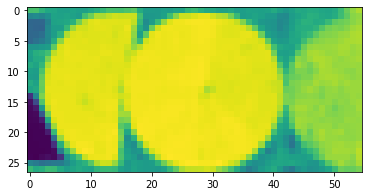

In [347]:
plt.imshow(ndvi_arr)

In [348]:
ndvi_arr

array([[ 0.3648119 ,  0.36644208,  0.3253519 , ...,  0.41102564,
         0.45744342,  0.48444334],
       [ 0.19573991,  0.21048743,  0.19232507, ...,  0.397848  ,
         0.4446938 ,  0.45701993],
       [ 0.10804322,  0.10606965,  0.10849288, ...,  0.42310804,
         0.44672614,  0.46076912],
       ...,
       [-0.11583121, -0.12212288, -0.10448603, ...,  0.46375158,
         0.44809687,  0.4901289 ],
       [ 0.18547517,  0.16412996,  0.13356401, ...,  0.4490322 ,
         0.43949643,  0.4766869 ],
       [ 0.34272364,  0.30065382,  0.30991173, ...,  0.40501988,
         0.4089768 ,  0.42712444]], dtype=float32)

In [349]:
ndvi_arr.shape[0]*ndvi_arr.shape[1]

1485

### Исходные данные (truth ground)

In [350]:
#/Users/the_icecream/Desktop/проверка/CR_alfa.tif
dataset = gdal.Open("/Users/the_icecream/Desktop/тестовые/CR.tif", gdal.GA_ReadOnly)
for x in range(1, dataset.RasterCount + 1):
    band = dataset.GetRasterBand(x)
    truth = band.ReadAsArray()

(27, 55)

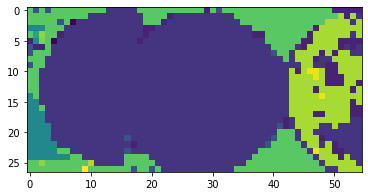

In [351]:
plt.imshow(truth)
truth.shape

In [352]:
truth

array([[176,  61, 176, ...,  24,  24,  24],
       [176, 176, 176, ...,  24, 205,  36],
       [176, 176, 176, ..., 205,  36, 205],
       ...,
       [111, 111, 111, ..., 205,  36,  36],
       [176, 176, 195, ..., 205, 205,  36],
       [176, 176, 176, ..., 205, 205, 205]], dtype=uint8)

In [353]:
array0 = np.array(truth, dtype = object)

In [354]:
array0.shape

(27, 55)

### Тренировочные данные Band01

In [69]:
#/Users/the_icecream/Desktop/проверка/Band01_alfa.tif
data01 = gdal.Open("/Users/the_icecream/Desktop/тестовые/b1.tif", gdal.GA_ReadOnly)
for x in range(1, data01.RasterCount + 1):
    band = data01.GetRasterBand(x)
    array01 = band.ReadAsArray()

(27, 55)

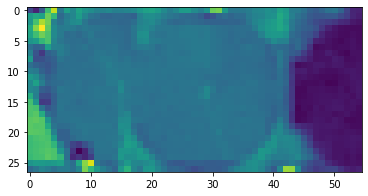

In [70]:
plt.imshow(array01)
array01.shape

### Тренировочные данные Band02

In [71]:
#/Users/the_icecream/Desktop/проверка/Band02_alfa.tif
data02 = gdal.Open("/Users/the_icecream/Desktop/тестовые/b2.tif", gdal.GA_ReadOnly)
for x in range(1, data02.RasterCount + 1):
    band = data02.GetRasterBand(x)
    array02 = band.ReadAsArray()

(27, 55)

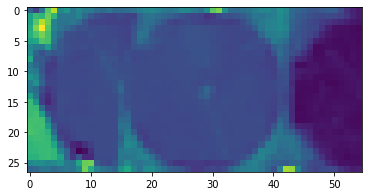

In [72]:
plt.imshow(array02)
array02.shape

### Тренировочные данные Band03

In [73]:
#/Users/the_icecream/Desktop/проверка/Band03_alfa.tif
data03 = gdal.Open("/Users/the_icecream/Desktop/тестовые/b3.tif", gdal.GA_ReadOnly)
for x in range(1, data03.RasterCount + 1):
    band = data03.GetRasterBand(x)
    array03 = band.ReadAsArray()

(27, 55)

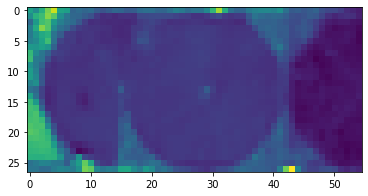

In [74]:
plt.imshow(array03)
array03.shape

### Тренировочные данные Band04

In [75]:
#/Users/the_icecream/Desktop/проверка/Band04_alfa.tif
data04 = gdal.Open("/Users/the_icecream/Desktop/тестовые/b4.tif", gdal.GA_ReadOnly)
for x in range(1, data04.RasterCount + 1):
    band = data04.GetRasterBand(x)
    array04 = band.ReadAsArray()

(27, 55)

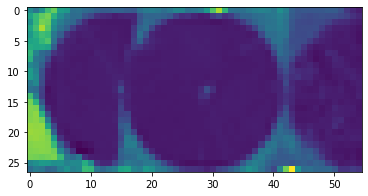

In [76]:
plt.imshow(array04)
array04.shape

### Тренировочные данные Band05

In [77]:
#/Users/the_icecream/Desktop/проверка/Band05_alfa.tif
data05 = gdal.Open("/Users/the_icecream/Desktop/тестовые/b5.tif", gdal.GA_ReadOnly)
for x in range(1, data05.RasterCount + 1):
    band = data05.GetRasterBand(x)
    array05 = band.ReadAsArray()

(27, 55)

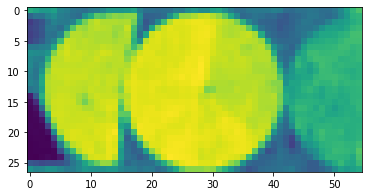

In [78]:
plt.imshow(array05)
array05.shape

### Тренировочные данные Band06

In [79]:
#/Users/the_icecream/Desktop/проверка/Band06_alfa.tif
data06 = gdal.Open("/Users/the_icecream/Desktop/тестовые/b6.tif", gdal.GA_ReadOnly)
for x in range(1, data06.RasterCount + 1):
    band = data06.GetRasterBand(x)
    array06 = band.ReadAsArray()

(27, 55)

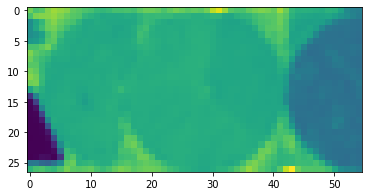

In [80]:
plt.imshow(array06)
array06.shape

### Тренировочные данные Band07

In [81]:
#/Users/the_icecream/Desktop/проверка/Band07_alfa.tif
data07 = gdal.Open("/Users/the_icecream/Desktop/тестовые/b7.tif", gdal.GA_ReadOnly)
for x in range(1, data07.RasterCount + 1):
    band = data07.GetRasterBand(x)
    array07 = band.ReadAsArray()

(27, 55)

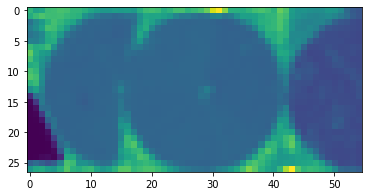

In [82]:
plt.imshow(array07)
array07.shape

In [83]:
np.unique(array07).shape

(897,)

### Тренировочные данные Band10

In [84]:
#/Users/the_icecream/Desktop/проверка/Band10_alfa.tif
data10 = gdal.Open("/Users/the_icecream/Desktop/тестовые/b10.tif", gdal.GA_ReadOnly)
for x in range(1, data10.RasterCount + 1):
    band = data10.GetRasterBand(x)
    array10 = band.ReadAsArray()

(27, 55)

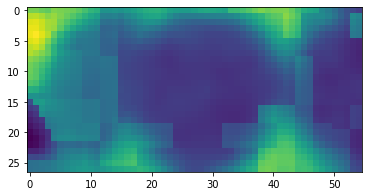

In [85]:
plt.imshow(array10)
array10.shape

In [86]:
bands0 = {0:array01, 1:array02, 2:array03, 3:array04, 4:array05, 5:array06, 6:array07, 7:array10}

##  Тестовые данные

In [7]:
NDVI = gdal.Open("/Users/the_icecream/Desktop/test_data_01/test_NDVI.tif", gdal.GA_ReadOnly)
for x in range(1, NDVI.RasterCount + 1):
    band = NDVI.GetRasterBand(x)
    ndvi_arr = band.ReadAsArray()

AttributeError: 'NoneType' object has no attribute 'RasterCount'

In [8]:
plt.imshow(ndvi_arr)

NameError: name 'ndvi_arr' is not defined

In [190]:
dataset = gdal.Open("/Users/the_icecream/Desktop/test_data_01/test_truth.tif", gdal.GA_ReadOnly)
for x in range(1, dataset.RasterCount + 1):
    band = dataset.GetRasterBand(x)
    truth = band.ReadAsArray()

(55, 83)

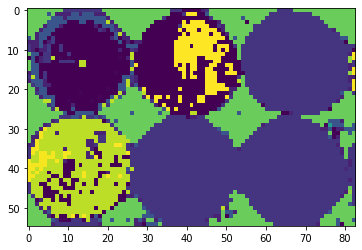

In [191]:
plt.imshow(truth)
truth.shape

In [192]:
array0 = np.array(truth, dtype = object)

In [193]:
array0.shape

(55, 83)

In [194]:
data01 = gdal.Open("/Users/the_icecream/Desktop/test_data_01/test_band1.tif", gdal.GA_ReadOnly)
for x in range(1, data01.RasterCount + 1):
    band = data01.GetRasterBand(x)
    array01 = band.ReadAsArray()

(55, 83)

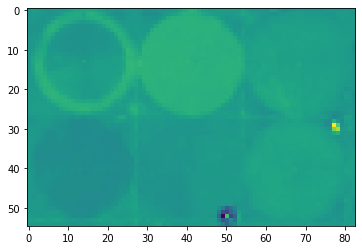

In [195]:
plt.imshow(array01)
array01.shape

In [196]:
data02 = gdal.Open("/Users/the_icecream/Desktop/test_data_01/test_band2.tif", gdal.GA_ReadOnly)
for x in range(1, data02.RasterCount + 1):
    band = data02.GetRasterBand(x)
    array02 = band.ReadAsArray()

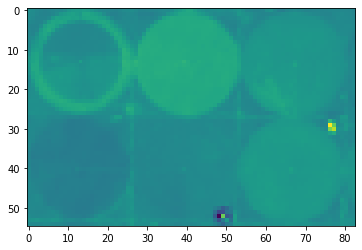

In [197]:
plt.imshow(array02)

In [198]:
data03 = gdal.Open("/Users/the_icecream/Desktop/test_data_01/test_band3.tif", gdal.GA_ReadOnly)
for x in range(1, data03.RasterCount + 1):
    band = data03.GetRasterBand(x)
    array03 = band.ReadAsArray()

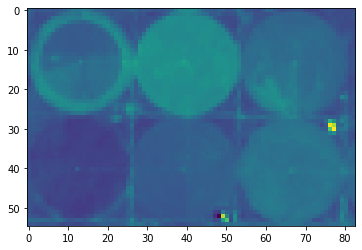

In [199]:
plt.imshow(array03)

In [200]:
data04 = gdal.Open("/Users/the_icecream/Desktop/test_data_01/test_band4.tif", gdal.GA_ReadOnly)
for x in range(1, data04.RasterCount + 1):
    band = data04.GetRasterBand(x)
    array04 = band.ReadAsArray()

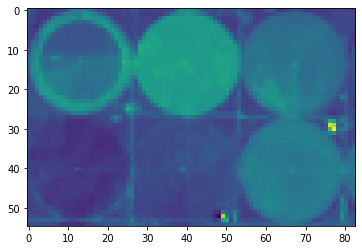

In [201]:
plt.imshow(array04)

In [202]:
data05 = gdal.Open("/Users/the_icecream/Desktop/test_data_01/test_band5.tif", gdal.GA_ReadOnly)
for x in range(1, data05.RasterCount + 1):
    band = data05.GetRasterBand(x)
    array05 = band.ReadAsArray()

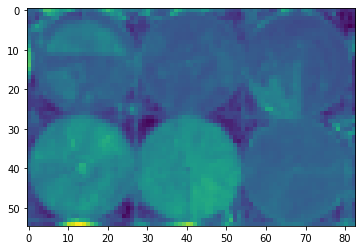

In [203]:
plt.imshow(array05)

In [204]:
data06 = gdal.Open("/Users/the_icecream/Desktop/test_data_01/test_band6.tif", gdal.GA_ReadOnly)
for x in range(1, data06.RasterCount + 1):
    band = data06.GetRasterBand(x)
    array06 = band.ReadAsArray()

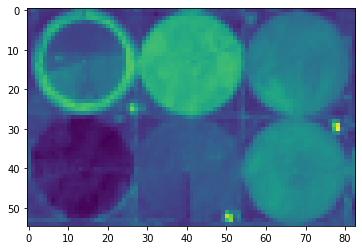

In [205]:
plt.imshow(array06)

In [206]:
data07 = gdal.Open("/Users/the_icecream/Desktop/test_data_01/test_band7.tif", gdal.GA_ReadOnly)
for x in range(1, data07.RasterCount + 1):
    band = data07.GetRasterBand(x)
    array07 = band.ReadAsArray()

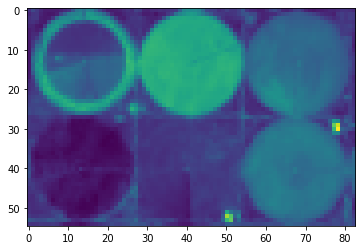

In [207]:
plt.imshow(array07)

In [208]:
data10 = gdal.Open("/Users/the_icecream/Desktop/test_data_01/test_band10.tif", gdal.GA_ReadOnly)
for x in range(1, data10.RasterCount + 1):
    band = data10.GetRasterBand(x)
    array10 = band.ReadAsArray()

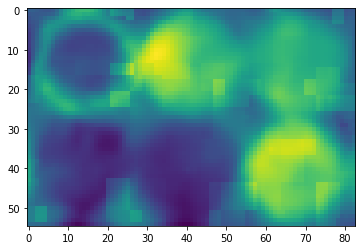

In [209]:
plt.imshow(array10)

In [210]:
bands0 = {0:array01, 1:array02, 2:array03, 3:array04, 4:array05, 5:array06, 6:array07, 7:array10}

## Data compression

In [211]:
def w_matr(n, lab):
    size = (n)*(n)
    w_matrix = np.zeros((size, size), dtype=object)
    for i in range(n):
        for j in range(n):
            num = (i)*n+j
            # cоседи по горизонтали
            if (num - 1 >= 0 and j != 0):
                if (lab[i][j-1] != -999):
                    w_matrix[num][num-1] = 1
            if (num + 1 < size and j != (n-1)):
                if (lab[i][j+1] != -999):
                    w_matrix[num][num+1] = 1
            
            # соседи по вертикали 
            if (num - lab.shape[1] >= 0):
                if (lab[i-1][j] != -999):
                    w_matrix[num][num -n] = 1
            if (num + lab.shape[1] < size):
                if (lab[i+1][j] != -999):
                    w_matrix[num][num + n] = 1
    return w_matrix  

In [212]:
def creat_size(label, n):
    size = n
    nstr = math.ceil(label.shape[0]/n)
    ncol = math.ceil(label.shape[1]/n)
    mat_I = np.zeros((nstr, ncol), dtype='int32')
    #print(nstr, ncol)
    numst = math.ceil(label.shape[0]/n)*n - label.shape[0]
    numcol = math.ceil(label.shape[1]/n)*n - label.shape[1]
    #print(numst, numcol)
    if (numst != 0):
        stri = np.array([[-999]*label.shape[1]]*numst)
        a = np.append(label, stri, axis = 0)
       # print(a.shape)
    else:
        a = label
    cols = np.array(([[-999]*numcol]*a.shape[0]), dtype = 'int32')
    nlab = np.append(a, cols, axis = 1)
    return (nlab, numst, numcol)

In [213]:
def MoransI(label, n, par, flag):
    size = n
    nstr = math.ceil(label.shape[0]/n)
    ncol = math.ceil(label.shape[1]/n)
    mat_I = np.zeros((nstr, ncol), dtype='int32')
    #print(nstr, ncol)
    numst = math.ceil(label.shape[0]/n)*n - label.shape[0]
    numcol = math.ceil(label.shape[1]/n)*n - label.shape[1]
    #print(numst, numcol)
    if (numst != 0):
        stri = np.array([[-999]*label.shape[1]]*numst)
        a = np.append(label, stri, axis = 0)
       # print(a.shape)
    else:
        a = label
    cols = np.array([[-999]*numcol]*a.shape[0])
    nlab = np.append(a, cols, axis = 1)
    print(nlab.shape)
    wmat = w_matr(n, nlab[0*n:0*n+n, 0*n:0*n+n])
    fl = True
    #print(wmat)
    for i in range (0, nstr):
        for j in range (0, ncol):
            tr = nlab[i*n:i*n+n, j*n:j*n+n]
            if (-999 in np.unique(tr)):
                wmat = w_matr(n, tr)
                fl = False
            elif (fl == False):
                wmat = w_matr(n, tr)
                fl = True
            mean = np.mean(tr)
            mor_I = 0
            N = 0
            W = 0
            for h in range(0,n):
                for t in range(0,n):
                    num = (h)*n+t
                    # cоседи по горизонтали
                    W += (tr[h][t] - mean)**2
                    if (num - 1 >= 0 and t != 0):
                        N += wmat[num][num-1]*(tr[h][t] - mean)*(tr[h][t-1]-mean)
                    if (num + 1 < size and t != (n-1)):
                        N += wmat[num][num+1]*(tr[h][t] - mean)*(tr[h][t+1]-mean)
                            
                    # соседи по вертикали 
                    if (num - label.shape[1] >= 0):
                        N += wmat[num][num-n]*(tr[h][t] - mean)*(tr[h-1][t]-mean)
                    if (num + label.shape[1] < size):
                        N += wmat[num][num+n]*(tr[h][t] - mean)*(tr[h+1][t]-mean)

            if (W == 0):
                mor_I = 1
            else:
                new_w_mat = w_matrix(label)
                mor_I = N/W*((label.shape[0]*label.shape[1])/np.sum(new_w_mat))
            if (flag):
                if (mor_I == par or mor_I == 1):
                    mat_I[i][j] = mean
                else:
                    mat_I[i][j] = -999
            else:
                if (mor_I >= par):
                    mat_I[i][j] = mean
                else:
                    mat_I[i][j] = -999
            print("Mor=", mor_I, mean, flag)
    return mat_I

In [275]:
def reverse_comp(comp_ar, array, n):
    t = creat_size(array, n)
    big_ar = t[0]
    new = t[1]
    new1 = t[2]
    for i in range(comp_ar.shape[0]):
        for j in range(comp_ar.shape[1]):
            if (comp_ar[i][j] == None):
                for h in range(i*n, i*n+n):
                    for t in range(j*n, j*n+n):
                        big_ar[h][t] = None
    if (new > 0) :
        big_ar = np.delete(big_ar, (big_ar.shape[0]-1, big_ar.shape[0]-2), 0)
    if (new1 > 0) :
        big_ar = np.delete(big_ar, (big_ar.shape[1]-1), 1)
    return big_ar

In [276]:
arr = reverse_comp(label1, label0, 3)

In [277]:
arr.shape

(55, 83)

In [278]:
array0.shape

(55, 83)

In [218]:
bands1 = {} 
for x in range(0,8):
    new = MoransI(bands0[x], 3, 0.0, 0)
    print(new)
    bands1[x] = new
    print("\n")

(57, 84)
Mor= -0.005644964297846541 8682.888888888889 0
Mor= 0.033294981398267656 8483.888888888889 0
Mor= 0.1294251001844565 8811.111111111111 0
Mor= 0.23272452108008268 9395.555555555555 0
Mor= 0.03169038719455838 9504.111111111111 0
Mor= 0.1984593909432628 9722.444444444445 0
Mor= 0.19224192777019633 9224.666666666666 0
Mor= 0.07295070276777735 8440.444444444445 0
Mor= 0.009386453158125415 8600.777777777777 0
Mor= 0.016240538990006475 8506.888888888889 0
Mor= 0.15359096461729072 8240.0 0
Mor= 0.06205515733792542 8755.444444444445 0
Mor= 0.2177653532943046 9454.111111111111 0
Mor= 0.10656769044739256 9996.444444444445 0
Mor= 0.08973979397098981 9753.111111111111 0
Mor= 0.21348488016700307 9233.222222222223 0
Mor= 0.03918314731146243 8824.0 0
Mor= 0.13059283207238606 8816.333333333334 0
Mor= 0.05994840082369394 9066.888888888889 0
Mor= 0.10207012107793366 8645.111111111111 0
Mor= 0.11334343984111767 8616.222222222223 0
Mor= 0.2409469378671215 8581.111111111111 0
Mor= 0.189144443788244

Mor= 0.039635751583838356 9686.888888888889 0
Mor= -0.04770415890609139 8801.888888888889 0
Mor= 0.010228798224191465 9408.666666666666 0
Mor= -0.08488261600456602 9589.555555555555 0
Mor= 0.08673464345164149 9478.666666666666 0
Mor= -0.018589614144736956 9365.666666666666 0
Mor= 0.012270683613269363 9208.666666666666 0
Mor= -0.0523414688353901 9163.444444444445 0
Mor= 0.055755191448685175 9191.555555555555 0
Mor= 0.04818658337105977 8846.888888888889 0
Mor= -0.026513555556932137 5376.333333333333 0
Mor= 0.06640877046353258 8895.666666666666 0
Mor= 0.10346225058793677 9436.666666666666 0
Mor= 0.04421717346618433 10114.0 0
Mor= 0.17861362933419975 9680.222222222223 0
Mor= 0.15453233731943838 9185.777777777777 0
Mor= 0.19126322116710434 9075.777777777777 0
Mor= 0.16302732654466628 9527.0 0
Mor= 0.14666740689693097 9861.222222222223 0
Mor= 0.0046516700657025884 9082.777777777777 0
Mor= -0.04273670089998063 9045.777777777777 0
Mor= 0.10064487738434352 9552.0 0
Mor= 0.02758926821931194 1012

Mor= 0.23376047059491645 8033.444444444444 0
Mor= 0.06048557856070311 8106.111111111111 0
Mor= 0.041335572850865865 8492.555555555555 0
Mor= -0.09554223899774451 8383.666666666666 0
Mor= 0.012989201437137887 8456.444444444445 0
Mor= 0.05383171619692702 8431.444444444445 0
Mor= 0.07688385358707844 8550.111111111111 0
Mor= 0.012155118899018238 8676.111111111111 0
Mor= 0.03111478198724617 8778.0 0
Mor= 0.024319296211208954 8751.0 0
Mor= 0.014752846879196603 8764.444444444445 0
Mor= 0.01566080558030759 9220.777777777777 0
Mor= 0.02853955432189138 9404.333333333334 0
Mor= 0.11570899120095957 9399.222222222223 0
Mor= 0.034993788663697276 9326.777777777777 0
Mor= -0.01691933907245458 9223.111111111111 0
Mor= 0.06875735084957584 9130.0 0
Mor= 0.16977400462505474 9231.888888888889 0
Mor= 0.1482183318786858 9223.444444444445 0
Mor= -0.048643241583548553 9090.777777777777 0
Mor= -0.02808784905659935 5738.666666666667 0
Mor= 0.01152396268315588 8533.222222222223 0
Mor= -0.06722717344639507 8256.44

Mor= 0.0164447023390062 8930.666666666666 0
Mor= 0.03017075312883039 8634.777777777777 0
Mor= 0.1943535378237558 9351.666666666666 0
Mor= 0.19285877909217516 9950.666666666666 0
Mor= -0.057682864400642464 10071.222222222223 0
Mor= 0.21952777384969627 10102.888888888889 0
Mor= 0.17862121298042996 9324.222222222223 0
Mor= -0.0032574385604290535 8635.222222222223 0
Mor= 0.19846301346601183 8907.555555555555 0
Mor= 0.01287208839513368 8672.111111111111 0
Mor= 0.11601208974196336 8613.555555555555 0
Mor= 0.13640999603470058 9346.333333333334 0
Mor= 0.18218736348832318 10157.111111111111 0
Mor= 0.02659370640697081 10580.333333333334 0
Mor= 0.1909291265198942 10084.222222222223 0
Mor= 0.12964903483779527 9395.0 0
Mor= 0.22496185848846997 8967.0 0
Mor= 0.06920027372019849 9192.111111111111 0
Mor= 0.18910523497956655 9211.777777777777 0
Mor= 0.08780682397013459 8716.888888888889 0
Mor= 0.10731097810357629 9067.0 0
Mor= 0.27428555187263803 8995.555555555555 0
Mor= 0.23539180661860348 9224.111111

Mor= 0.010876477060524957 9393.222222222223 0
Mor= 0.2249856047908325 10028.777777777777 0
Mor= -0.024730578961418285 10318.333333333334 0
Mor= 0.08998234639799269 9900.444444444445 0
Mor= -0.047238069591936854 9853.888888888889 0
Mor= -0.04602066143285057 9622.777777777777 0
Mor= -0.050488255559744226 9697.555555555555 0
Mor= 0.0011092870400008096 9549.333333333334 0
Mor= 0.06189729172649299 9062.888888888889 0
Mor= -0.031046832340122968 5534.333333333333 0
Mor= -0.021013325302573476 9224.333333333334 0
Mor= 0.13394441052497483 10235.0 0
Mor= 0.1266159661172285 10565.777777777777 0
Mor= 0.17958487745976032 10010.0 0
Mor= 0.2068231531806732 9618.444444444445 0
Mor= 0.17471770316124643 9632.444444444445 0
Mor= 0.11337730001628994 10333.333333333334 0
Mor= 0.15435705058209223 10066.888888888889 0
Mor= -0.15495552484823763 9312.444444444445 0
Mor= 0.04261316454245811 9253.777777777777 0
Mor= 0.07285641945637893 10425.777777777777 0
Mor= 0.05570795872861159 10741.111111111111 0
Mor= -0.055

Mor= 0.22665182645003448 8336.555555555555 0
Mor= -0.006776289211803757 8673.333333333334 0
Mor= 0.05793728157001435 8757.333333333334 0
Mor= 0.0822919623168788 8758.0 0
Mor= 0.007929394039589251 8782.888888888889 0
Mor= 0.006487908911977226 8788.555555555555 0
Mor= 0.0631536555762453 8961.111111111111 0
Mor= -0.004667355880987403 8976.222222222223 0
Mor= -0.1244765904689019 9013.0 0
Mor= 0.021610168336528103 8955.666666666666 0
Mor= 0.002485073098973487 9237.333333333334 0
Mor= -0.007319351519931397 9876.777777777777 0
Mor= -0.02921914659593638 9871.0 0
Mor= 0.17193271153382927 9873.222222222223 0
Mor= -0.06350994871601393 9784.555555555555 0
Mor= 0.05526314056857022 9771.555555555555 0
Mor= 0.1055696320102807 9717.111111111111 0
Mor= 0.18504490975772772 9776.444444444445 0
Mor= 0.016273010844119987 9789.888888888889 0
Mor= 0.10538587327872517 9714.0 0
Mor= -0.030023916197932397 6090.444444444444 0
Mor= 0.09800411437817641 8640.222222222223 0
Mor= 0.147848158388714 8528.666666666666 0

Mor= 0.06626146867749957 10122.444444444445 0
Mor= 0.19352304366530565 9964.111111111111 0
Mor= 0.1894004628400819 10592.888888888889 0
Mor= 0.17228060622419494 11168.888888888889 0
Mor= -0.032888893755727906 11401.777777777777 0
Mor= 0.20567616957942228 11424.111111111111 0
Mor= 0.19284699410882566 10768.111111111111 0
Mor= 0.0005835136434111626 10091.777777777777 0
Mor= 0.21917669836423928 10091.777777777777 0
Mor= 0.06306171719140072 10050.111111111111 0
Mor= 0.17923396383510234 9858.111111111111 0
Mor= 0.1334436919561074 10586.666666666666 0
Mor= 0.11036239174242772 11700.666666666666 0
Mor= 0.03525829299867531 12047.777777777777 0
Mor= 0.1006479927651456 11597.111111111111 0
Mor= 0.1075395299306284 10618.777777777777 0
Mor= 0.164167834593982 10041.333333333334 0
Mor= 0.06285790190645707 10192.222222222223 0
Mor= 0.2156111656211117 10478.444444444445 0
Mor= -0.10954599672612539 9878.777777777777 0
Mor= 0.12222595821207687 10386.666666666666 0
Mor= 0.284490335459262 10285.3333333333

Mor= 0.22496448516401302 12134.444444444445 0
Mor= 0.0033951827292580936 12196.777777777777 0
Mor= 0.09192318480838663 12199.444444444445 0
Mor= 0.1316166452941855 12273.333333333334 0
Mor= 0.0847581613149107 11195.777777777777 0
Mor= -0.013595390989441195 10843.444444444445 0
Mor= 0.21785700884589648 11511.777777777777 0
Mor= -0.051970657793357466 11991.888888888889 0
Mor= -0.0027221136438980637 11280.0 0
Mor= -0.061667409039395105 11313.333333333334 0
Mor= 0.005899329422319698 10823.0 0
Mor= -0.07741412047527808 11039.111111111111 0
Mor= -0.003640546565635933 10728.0 0
Mor= 0.0456509056007019 10255.444444444445 0
Mor= -0.03057772185480007 6162.888888888889 0
Mor= 0.022909272410337432 10351.222222222223 0
Mor= 0.14665239740644992 11508.888888888889 0
Mor= 0.0925627565732547 11985.666666666666 0
Mor= 0.1568114484054218 11512.888888888889 0
Mor= 0.20640649640586098 11121.111111111111 0
Mor= 0.17697799887615137 11097.777777777777 0
Mor= 0.08109966231832151 11708.222222222223 0
Mor= 0.144

Mor= 0.055249253348068864 9630.666666666666 0
Mor= -0.1440318638161395 9623.111111111111 0
Mor= -0.09962590833256367 9539.555555555555 0
Mor= 0.04709445540279329 9550.0 0
Mor= 0.22745022282920624 9485.888888888889 0
Mor= 0.1654215886454757 9492.555555555555 0
Mor= 0.16483554430458564 9479.0 0
Mor= -0.017872963880718143 10006.0 0
Mor= 0.0813421949652057 10287.333333333334 0
Mor= 0.15703556214389672 10290.111111111111 0
Mor= 0.17470359946917421 10300.444444444445 0
Mor= 0.014111511879779047 10340.0 0
Mor= 0.017133923976116718 10585.444444444445 0
Mor= -0.008479795830340375 10457.111111111111 0
Mor= -0.04190392670511961 10454.666666666666 0
Mor= -0.02670552862420848 10370.444444444445 0
Mor= 0.020570469798946917 10694.666666666666 0
Mor= 0.05516939698038312 11236.666666666666 0
Mor= -0.013746604754247707 11157.444444444445 0
Mor= 0.19495001103261173 11180.222222222223 0
Mor= 0.20502169268533657 11111.777777777777 0
Mor= 0.09135083485853558 11251.777777777777 0
Mor= 0.13302191386935663 110

Mor= 0.039579526542910165 9679.222222222223 0
Mor= 0.057845605957686334 9106.777777777777 0
Mor= 0.1964707017103241 10534.555555555555 0
Mor= 0.18882593899962302 11874.666666666666 0
Mor= -0.040747171564691084 12314.888888888889 0
Mor= 0.20300588417541252 12315.888888888889 0
Mor= 0.20236014677460276 10674.666666666666 0
Mor= 0.019260638099198844 9413.0 0
Mor= 0.07169320256769682 9704.111111111111 0
Mor= 0.03553511726965864 9568.888888888889 0
Mor= 0.25671841275689455 9396.222222222223 0
Mor= 0.1425529567212899 10520.777777777777 0
Mor= 0.16782598541892824 12388.555555555555 0
Mor= 0.22936908042252865 13162.333333333334 0
Mor= 0.14646321392244166 12377.888888888889 0
Mor= 0.12862065516333918 10694.111111111111 0
Mor= 0.19244360255573678 9735.222222222223 0
Mor= 0.04375193513945627 10093.333333333334 0
Mor= 0.20387273368295522 10258.111111111111 0
Mor= -0.07832168924724935 9332.888888888889 0
Mor= 0.1084579154603347 10309.444444444445 0
Mor= 0.27690699739464764 10356.777777777777 0
Mor=

Mor= 0.17523215152860186 13621.0 0
Mor= -0.0022210042048493948 13729.0 0
Mor= 0.08740733982446354 13739.777777777777 0
Mor= 0.13867144528038963 13859.444444444445 0
Mor= 0.0634854699103793 11880.666666666666 0
Mor= 0.008588190866281306 11081.666666666666 0
Mor= 0.18918355218426716 12391.222222222223 0
Mor= -0.03977381916798158 12955.333333333334 0
Mor= 0.029415924589053278 12050.666666666666 0
Mor= -0.06645361750484442 12105.333333333334 0
Mor= -0.0011633417245106926 11483.777777777777 0
Mor= -0.09657153282096191 11839.0 0
Mor= 0.0018099674055052763 11394.666666666666 0
Mor= 0.04526940443879184 10487.222222222223 0
Mor= -0.03152256070253067 6153.0 0
Mor= -0.06825044407424294 10202.333333333334 0
Mor= 0.14781541205549278 12319.222222222223 0
Mor= 0.13584937915877002 13170.0 0
Mor= 0.17308176492143537 12380.0 0
Mor= 0.21434699084442052 11835.333333333334 0
Mor= 0.1819321070556899 11847.666666666666 0
Mor= 0.08174516343317463 12788.777777777777 0
Mor= 0.15154160657665564 12036.11111111111

Mor= -0.04913548750613954 9273.555555555555 0
Mor= 0.049511304438693504 9338.555555555555 0
Mor= -0.020749565303132003 9343.777777777777 0
Mor= -0.07287234561152064 9163.666666666666 0
Mor= 0.08188388918862924 9060.333333333334 0
Mor= 0.21594025661198624 9105.333333333334 0
Mor= 0.18083631156213126 9084.666666666666 0
Mor= 0.1803178497680485 9090.111111111111 0
Mor= -0.014694967928726313 9858.666666666666 0
Mor= 0.0030850125662057947 9954.555555555555 0
Mor= 0.1458133727994854 9867.111111111111 0
Mor= 0.14010954697366898 9911.111111111111 0
Mor= -0.0018285882278790905 9989.777777777777 0
Mor= 0.025227139016310483 10277.777777777777 0
Mor= 0.08844901340261166 9981.777777777777 0
Mor= 0.05317498482198768 9952.0 0
Mor= 0.0009026902361677165 9829.111111111111 0
Mor= -0.0018935828050641772 10743.0 0
Mor= 0.04122455737209755 12196.444444444445 0
Mor= -0.016454245164596763 12116.666666666666 0
Mor= 0.16447027654316126 12093.555555555555 0
Mor= 0.19872177016374035 11940.444444444445 0
Mor= 0.1

Mor= 0.0805916344206958 17823.222222222223 0
Mor= 0.1582903109058813 20521.777777777777 0
Mor= 0.1337374536249568 20629.0 0
Mor= 0.28648235371114483 18834.11111111111 0
Mor= 0.05252053522795971 17818.777777777777 0
Mor= 0.15534370640512885 18165.555555555555 0
Mor= 0.2264370212082063 19752.88888888889 0
Mor= 0.10094498944728361 20632.333333333332 0
Mor= 0.023149149974227234 18835.222222222223 0
Mor= 0.10355338098180156 18637.88888888889 0
Mor= -0.002965765099691381 19325.666666666668 0
Mor= 0.07787865059571211 18183.555555555555 0
Mor= 0.18174317084475608 19926.88888888889 0
Mor= 0.2265880306588363 18616.222222222223 0
Mor= 0.22945967430574504 18815.88888888889 0
Mor= 0.1740683803040573 18418.88888888889 0
Mor= 0.15701422280220534 17561.555555555555 0
Mor= 0.1764125246280999 16359.666666666666 0
Mor= 0.021283290736432328 18230.0 0
Mor= 0.020065560546328725 18167.555555555555 0
Mor= 0.17903212390143722 17935.333333333332 0
Mor= 0.1848546472548445 19305.555555555555 0
Mor= 0.119727859707

Mor= -0.01884200755001925 18358.11111111111 0
Mor= 0.18738910446584436 18201.88888888889 0
Mor= 0.03827605095064256 18138.777777777777 0
Mor= -0.0038798246834848764 18303.555555555555 0
Mor= 0.16227107868298535 19039.222222222223 0
Mor= -0.028415888310987437 19645.333333333332 0
Mor= 0.0015520246062606525 19023.777777777777 0
Mor= -0.11202130643565265 19175.88888888889 0
Mor= 0.00234990036464205 17991.666666666668 0
Mor= -0.017543129742621594 17937.88888888889 0
Mor= 0.0006593540245298064 17838.333333333332 0
Mor= -0.008116477011755161 17534.222222222223 0
Mor= -0.018973976778698408 10939.555555555555 0
Mor= 0.1264465323910142 16888.11111111111 0
Mor= 0.20633641822677365 17241.666666666668 0
Mor= 0.17847142346833397 18243.555555555555 0
Mor= 0.17832474882123958 19226.0 0
Mor= -0.09923948262845089 18392.11111111111 0
Mor= 0.016786262358990067 18735.0 0
Mor= 0.1827264583364537 18385.555555555555 0
Mor= -0.03688705003037584 18326.666666666668 0
Mor= 0.013223441587485259 17225.333333333332

Mor= -0.030530119828779324 21630.333333333332 0
Mor= 0.06293841946170206 20238.444444444445 0
Mor= 0.006788262042896946 20231.777777777777 0
Mor= -0.05994542392708937 20103.666666666668 0
Mor= 0.20592023637790213 20014.11111111111 0
Mor= 0.007166618347124501 19956.11111111111 0
Mor= 0.06623009580402117 20842.777777777777 0
Mor= 0.01672296579107137 20693.222222222223 0
Mor= 0.12725991492350605 20440.11111111111 0
Mor= 0.0859808042021371 20821.222222222223 0
Mor= 0.0037075013781260493 21408.0 0
Mor= 0.027390896166943957 21541.333333333332 0
Mor= -0.054651390424208274 21550.666666666668 0
Mor= 0.09898553505213464 21077.88888888889 0
Mor= 0.0685655201977054 18827.0 0
Mor= -0.06709635074024993 18378.444444444445 0
Mor= 0.21640665297836 18352.88888888889 0
Mor= 0.13217196306487156 18492.0 0
Mor= 0.20199411508531961 18769.555555555555 0
Mor= 0.22594201940016145 18623.11111111111 0
Mor= 0.2690203945759246 18620.666666666668 0
Mor= 0.1455395980894829 18732.777777777777 0
Mor= -0.088800485718469

Mor= 0.017721117558228205 15736.888888888889 0
Mor= 0.21464780320168525 14649.666666666666 0
Mor= 0.14115738361215407 16132.222222222223 0
Mor= 0.22961972057796987 18859.88888888889 0
Mor= 0.06955287482703983 20123.555555555555 0
Mor= 0.18479447377860614 21121.88888888889 0
Mor= 0.2320361078560757 18534.444444444445 0
Mor= 0.08835901954607941 15406.111111111111 0
Mor= 0.0388355518467493 15248.777777777777 0
Mor= 0.04927112651298341 15390.444444444445 0
Mor= 0.09076952628629203 14688.888888888889 0
Mor= 0.09304853486485071 15822.555555555555 0
Mor= 0.19790496697144833 18997.555555555555 0
Mor= 0.22961460482318172 21063.666666666668 0
Mor= 0.11983109174923919 20617.777777777777 0
Mor= 0.19333263740795928 18089.555555555555 0
Mor= -0.008097637085090542 15547.555555555555 0
Mor= 0.06476738543472665 15404.666666666666 0
Mor= 0.12350018862055892 16730.333333333332 0
Mor= 0.028078170076466936 15362.0 0
Mor= 0.06693872599584685 15821.333333333334 0
Mor= 0.2486247530978292 16806.555555555555 0


Mor= -0.1339747152130794 22156.555555555555 0
Mor= -0.02129659322825992 22525.555555555555 0
Mor= 0.18064112501516558 22258.11111111111 0
Mor= 0.0436998893935271 20872.11111111111 0
Mor= -0.0424865280761723 16777.666666666668 0
Mor= 0.034281735067682895 19909.222222222223 0
Mor= 0.03576890993623642 20779.666666666668 0
Mor= 0.120075714219652 20307.333333333332 0
Mor= 0.025487282548434673 19767.666666666668 0
Mor= 0.12768728942434585 19231.222222222223 0
Mor= 0.013724455654413879 19100.0 0
Mor= 0.0035012972591755864 19339.555555555555 0
Mor= 0.02125210931451984 17799.0 0
Mor= -0.022681895514980756 9911.222222222223 0
Mor= 0.10699742702788308 16209.888888888889 0
Mor= 0.10816387218249476 18758.555555555555 0
Mor= 0.01968135550216303 22010.222222222223 0
Mor= 0.20186133970282558 20571.555555555555 0
Mor= 0.19229365023803946 18511.88888888889 0
Mor= 0.1790885616873727 18603.666666666668 0
Mor= 0.19328178766267234 20227.666666666668 0
Mor= 0.11953220191008593 21292.555555555555 0
Mor= 0.014

Mor= 0.030795187267163238 13674.666666666666 0
Mor= 0.053918078094661634 13534.777777777777 0
Mor= 0.12453669135414493 13729.666666666666 0
Mor= 0.1498665626148723 13651.888888888889 0
Mor= 0.10735270422899564 13995.888888888889 0
Mor= 0.09100381130570553 16389.11111111111 0
Mor= 0.065015871094858 16435.444444444445 0
Mor= 0.09540453748296511 16346.666666666666 0
Mor= -0.11034942001211345 16381.222222222223 0
Mor= 0.07779889827419559 16884.444444444445 0
Mor= 0.11158151364156371 16949.222222222223 0
Mor= 0.010567989381411062 16950.333333333332 0
Mor= -0.002958000505379205 16688.666666666668 0
Mor= 0.06082531239935353 17207.777777777777 0
Mor= 0.025327489944636534 19758.444444444445 0
Mor= 0.09265855573665026 20334.222222222223 0
Mor= -0.053930591703408 20146.11111111111 0
Mor= 0.019108365960942737 19773.11111111111 0
Mor= 0.07227371187650143 19482.777777777777 0
Mor= 0.051059586186872695 19177.88888888889 0
Mor= 0.13381374470282778 19517.777777777777 0
Mor= 0.1829265557368282 19698.222

Mor= 0.018346327983501668 12343.222222222223 0
Mor= -0.015028302803629595 11122.0 0
Mor= 0.1380590854362855 12601.111111111111 0
Mor= 0.24698401512909043 15386.777777777777 0
Mor= 0.07284757670054652 16841.777777777777 0
Mor= 0.19083769484600444 17671.88888888889 0
Mor= 0.22620230260783172 15046.666666666666 0
Mor= 0.08121249710005188 11854.444444444445 0
Mor= 0.00262831970292442 11888.0 0
Mor= 0.04316348762086352 12142.0 0
Mor= 0.12426212536479433 11374.0 0
Mor= 0.08540320198180645 12652.777777777777 0
Mor= 0.20751094477878793 16033.555555555555 0
Mor= 0.2199668919775924 18466.11111111111 0
Mor= 0.1503984727505417 17886.666666666668 0
Mor= 0.19605108653983114 15085.0 0
Mor= -0.009593649647042093 12433.333333333334 0
Mor= 0.038821141337689144 12390.0 0
Mor= 0.113652611028866 13511.444444444445 0
Mor= 0.04074247226621667 11974.333333333334 0
Mor= 0.06666659915282243 12453.111111111111 0
Mor= 0.23962649650869716 13285.444444444445 0
Mor= 0.22369624992324014 13780.222222222223 0
Mor= 0.26

Mor= 0.02166661410789383 20008.333333333332 0
Mor= 0.1575466777824703 19739.11111111111 0
Mor= 0.043179666912242606 18200.777777777777 0
Mor= -0.054520542169258876 13579.777777777777 0
Mor= -0.013476081150494203 16401.11111111111 0
Mor= 0.06212215217419593 17240.11111111111 0
Mor= 0.13188753996887595 16771.333333333332 0
Mor= -0.020966523595526736 16137.777777777777 0
Mor= 0.15606005414865304 15716.333333333334 0
Mor= 0.015066873984784733 15529.333333333334 0
Mor= 0.0013009903247967489 15682.111111111111 0
Mor= 0.02214975637987612 14228.444444444445 0
Mor= -0.022614372360665772 7924.666666666667 0
Mor= 0.11901736694816159 12907.666666666666 0
Mor= 0.10638246243614613 15632.222222222223 0
Mor= 0.027845001852887984 18868.222222222223 0
Mor= 0.20422538831140968 17295.222222222223 0
Mor= 0.19454630454148894 15377.666666666666 0
Mor= 0.17662419547979552 15308.777777777777 0
Mor= 0.1921708843993501 17020.333333333332 0
Mor= 0.1387792417304949 18120.777777777777 0
Mor= 0.01190787500502912 139

Mor= -0.016477912867612007 11219.555555555555 0
Mor= 0.0033443173217610972 11169.777777777777 0
Mor= 0.06074349758921192 10816.111111111111 0
Mor= 0.09179678482085435 10736.888888888889 0
Mor= 0.1736263200927974 10857.555555555555 0
Mor= 0.1887345676948701 10782.222222222223 0
Mor= 0.09048562073019237 11153.111111111111 0
Mor= 0.026038270127175193 12788.111111111111 0
Mor= 0.010739705627536544 12353.333333333334 0
Mor= 0.11884819435135921 12312.0 0
Mor= -0.017733756803865134 12350.888888888889 0
Mor= 0.0628740152391617 12852.666666666666 0
Mor= 0.071284953467307 12771.0 0
Mor= -0.010633006339685799 12766.777777777777 0
Mor= 0.004200382588332673 12521.444444444445 0
Mor= 0.0002352245211581073 13284.111111111111 0
Mor= 0.02823946066621437 15911.666666666666 0
Mor= 0.06879822010025477 16564.0 0
Mor= -0.012182031463508165 16446.444444444445 0
Mor= 0.04715362935315519 16003.222222222223 0
Mor= 0.00032982827217870937 15784.555555555555 0
Mor= 0.07772104741268442 15543.666666666666 0
Mor= 0.2

Mor= 0.14696905882318345 46182.666666666664 0
Mor= 0.17947206029876508 46267.88888888889 0
Mor= 0.07961966451742031 46667.333333333336 0
Mor= 0.016270403813836775 47445.666666666664 0
Mor= 0.22691964229863062 47678.444444444445 0
Mor= 0.21703644058220334 47551.77777777778 0
Mor= 0.0029043031078215997 47101.11111111111 0
Mor= 0.11903487227218856 46972.666666666664 0
Mor= -0.03153593836253085 46747.11111111111 0
Mor= 0.20515654043167691 46108.11111111111 0
Mor= 0.13699801258020353 46318.0 0
Mor= 0.16468513732726583 46814.11111111111 0
Mor= 0.2077520543561219 47346.0 0
Mor= 0.23457853607115287 47531.0 0
Mor= 0.21191771335058213 47131.77777777778 0
Mor= 0.20223517947635442 46824.22222222222 0
Mor= 0.09939664118055246 46554.0 0
Mor= 0.22992555512102172 46425.77777777778 0
Mor= 0.22573869965228333 46438.0 0
Mor= 0.18257658475925145 46496.555555555555 0
Mor= 0.009056667138474202 46957.555555555555 0
Mor= 0.22676133477639243 47251.22222222222 0
Mor= 0.24019664012633926 47136.22222222222 0
Mor=

Mor= -0.0157682358194783 48159.88888888889 0
Mor= 0.07002043822965003 47475.666666666664 0
Mor= 0.2094697782034704 47251.22222222222 0
Mor= -0.041182275450822425 47610.88888888889 0
Mor= 0.07307588548233035 47971.333333333336 0
Mor= 0.15511092415021188 48080.77777777778 0
Mor= 0.13576382621016495 47876.0 0
Mor= -0.05080265136870383 48060.88888888889 0
Mor= 0.007132527566431692 47999.444444444445 0
Mor= 0.017095690157346882 47773.333333333336 0
Mor= 0.00394211270144692 47179.666666666664 0
Mor= -0.028278555676414487 30767.555555555555 0
Mor= -0.00025066994677794724 46866.0 0
Mor= 0.10871177477314616 47374.333333333336 0
Mor= 0.11643489171562683 47580.22222222222 0
Mor= 0.19804952891934643 47240.88888888889 0
Mor= 0.2316487763022548 46836.555555555555 0
Mor= 0.23745883882813384 46908.666666666664 0
Mor= 0.2254434626441377 47158.555555555555 0
Mor= 0.01059373623169525 47984.555555555555 0
Mor= -0.010677615648677629 47705.444444444445 0
Mor= 0.1974439948818997 47156.22222222222 0
Mor= 0.15

Mor= 0.06407144254918404 45806.444444444445 0
Mor= 0.007623549847276141 45623.88888888889 0
Mor= 0.16814083984268272 45566.22222222222 0
Mor= 0.02220224576518388 45504.666666666664 0
Mor= 0.005244978915991615 45532.22222222222 0
Mor= 0.08921820122641219 45664.0 0
Mor= 0.06214071378234184 45702.22222222222 0
Mor= 0.006702655935575307 45556.555555555555 0
Mor= -0.028278834185591357 45488.555555555555 0
Mor= 0.12790477568638803 45519.11111111111 0
Mor= 0.10867160878917867 45631.0 0
Mor= 0.21104145562563598 45676.333333333336 0
Mor= 0.2356498897961612 45737.333333333336 0
Mor= 0.02745961157209727 45826.666666666664 0
Mor= -0.007202539022077119 46404.555555555555 0
Mor= -0.0017530309893656337 47989.11111111111 0
Mor= 0.021187071516628277 48755.22222222222 0
Mor= 0.0023451404734633552 48724.11111111111 0
Mor= 0.06255334675911707 48594.444444444445 0
Mor= 0.08249405529360658 48378.555555555555 0
Mor= 0.10688550579529674 48163.666666666664 0
Mor= 0.2355181297870138 48212.555555555555 0
Mor= 0.

## Making matrix of features

In [219]:
bands0

{0: array([[8576, 8856, 8835, ..., 8668, 8600, 8496],
        [8390, 8753, 8811, ..., 8840, 8707, 8589],
        [8478, 8734, 8713, ..., 8853, 8778, 8683],
        ...,
        [8838, 8767, 8657, ..., 9143, 8690, 8681],
        [9067, 9065, 9227, ..., 8942, 8914, 8923],
        [8765, 8707, 8694, ..., 8857, 8891, 8890]], dtype=uint16),
 1: array([[9141, 9074, 8776, ..., 8784, 8722, 8609],
        [9074, 9004, 8718, ..., 8873, 8816, 8670],
        [9040, 8899, 8650, ..., 8929, 8887, 8722],
        ...,
        [9015, 8890, 8817, ..., 9142, 9008, 9017],
        [9323, 9468, 9593, ..., 9387, 9317, 9185],
        [8936, 8903, 8872, ..., 9377, 9244, 9162]], dtype=uint16),
 2: array([[10626, 10359,  9983, ...,  9722,  9725,  9721],
        [10415, 10089,  9696, ...,  9668,  9720,  9881],
        [10316,  9920,  9698, ...,  9626,  9756,  9830],
        ...,
        [10075,  9975,  9866, ..., 10773, 10453, 10174],
        [10765, 10625, 10716, ..., 11093, 10754, 10618],
        [10072, 10151, 

In [220]:
bands1

{0: array([[ -999,  8483,  8811,  9395,  9504,  9722,  9224,  8440,  8600,
          8506,  8240,  8755,  9454,  9996,  9753,  9233,  8824,  8816,
          9066,  8645,  8616,  8581,  8777,  8724,  8688,  8570,  8733,
          -999],
        [ 8425,  9005,  9754,  8923,  8511,  8588,  9287,  9657,  8887,
          -999,  9090, 10028, 10128,  -999, 10153, 10142,  9599,  8572,
          8881,  8764,  9028,  9118,  9119,  9091,  9052,  8959,  8818,
          -999],
        [ 8585,  -999,  8666,  8359,  8311,  8362,  8420,  9192,  9535,
          8979,  -999, 10135, 10119,  -999,  -999,  -999, 10007,  9537,
          8962,  9138,  9157,  -999,  9204,  -999,  9185,  -999,  8989,
          -999],
        [ 8892,  -999,  8550,  8433,  8382,  8444,  8543,  8766,  -999,
          -999,  -999,  -999,  -999,  -999,  -999,  -999, 10030, 10015,
          -999,  -999,  9309,  9151,  9177,  9153,  9105,  9061,  8924,
          -999],
        [ -999,  -999,  8918,  8842,  8729,  8828,  9002,  9063, 

In [221]:
features = np.zeros((array0.shape[0], array0.shape[1]), dtype = tuple)
for i in range(array0.shape[0]):
    for j in range(array0.shape[1]):
        features[i][j] = (bands0[0][i][j], bands0[1][i][j], bands0[2][i][j], bands0[3][i][j], bands0[4][i][j], bands0[5][i][j], bands0[6][i][j], bands0[7][i][j])

In [222]:
features

array([[(8576, 9141, 10626, 10439, 18348, 15621, 12189, 46263),
        (8856, 9074, 10359, 9995, 18265, 16840, 13320, 46288),
        (8835, 8776, 9983, 9302, 18757, 15922, 12545, 46232), ...,
        (8668, 8784, 9722, 9367, 15426, 15036, 12189, 46093),
        (8600, 8722, 9725, 9333, 15780, 14919, 11956, 46126),
        (8496, 8609, 9721, 9349, 15948, 14709, 11803, 46162)],
       [(8390, 9074, 10415, 9928, 18024, 14971, 11595, 46134),
        (8753, 9004, 10089, 9716, 18057, 15686, 12264, 46180),
        (8811, 8718, 9696, 9151, 17090, 15797, 12431, 46172), ...,
        (8840, 8873, 9668, 9569, 15236, 15229, 12387, 46176),
        (8707, 8816, 9720, 9566, 14865, 15472, 12673, 46216),
        (8589, 8670, 9881, 9561, 15544, 15432, 12555, 46233)],
       [(8478, 9040, 10316, 9958, 17488, 15271, 11951, 46009),
        (8734, 8899, 9920, 9600, 17820, 15823, 12398, 46157),
        (8713, 8650, 9698, 9024, 16560, 15701, 12396, 46209), ...,
        (8853, 8929, 9626, 9634, 15609, 15154, 

### Составим класс смежностей

In [223]:
label0 = np.where(ndvi_arr > 0.1, truth, 0)

In [224]:
label0

array([[176, 176, 176, ..., 176, 176, 176],
       [176, 176, 176, ..., 176, 176, 176],
       [176, 176, 176, ..., 176, 176, 176],
       ...,
       [176, 176, 176, ..., 176, 176, 176],
       [176, 176, 176, ..., 176, 176,  61],
       [176, 176, 176, ..., 176, 176, 176]], dtype=uint8)

In [357]:
def percent_error(label):
    right = np.sum(label == truth)
    ans = right/(label.shape[0]*label.shape[1])
    return ans  

In [358]:
def finding_ndvi():
    nd = 0.1
    x1 = []
    y1 = []
    while nd <= 1.0:
        label = np.where(ndvi_arr > nd, truth, 0)
        x1.append(nd)
        er = percent_error(label)
        y1.append(er)
        nd += 0.01
        nd = round(nd, 2)
    return (x1, y1)

In [359]:
ndv_par = finding_ndvi()

In [360]:
data = np.array([ndv_par[0], ndv_par[1]])
ind = ["NDVI", "correct per."]
df = pd.DataFrame(data=data, index = ind)
df

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
NDVI,0.100000,0.110000,0.120000,0.130000,0.140000,0.150000,0.16000,0.170000,0.180000,0.190000,...,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1.0
correct per.,0.974411,0.971044,0.967677,0.967003,0.964983,0.963636,0.96229,0.958249,0.958249,0.956229,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0


/Users/the_icecream/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


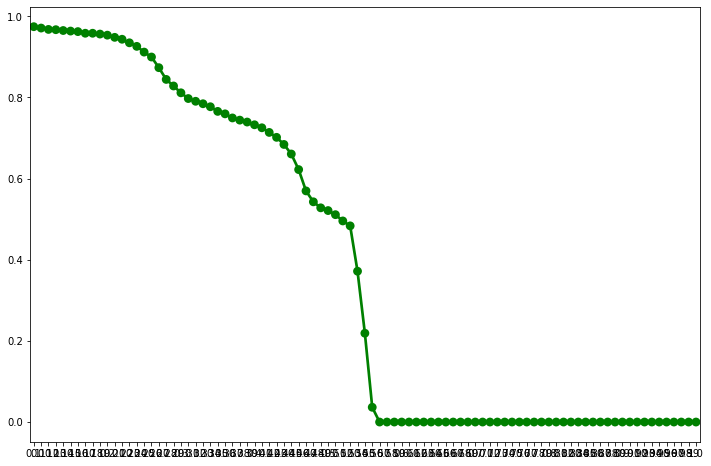

In [361]:
fig, ax = plt.subplots(figsize=(12,8))    
sns.pointplot(ndv_par[0],ndv_par[1], jitter=0.25, size=3, color="green")
plt.show()

## Составим матрицу смежности

In [266]:
#построение матрицы смежности
#номер пикселя == (i-1)*array.shape[1]+j

def w_matrix(array):
    size = (array.shape[0])*(array.shape[1])
    w_matrix = np.zeros((size, size), dtype=object)
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            num = (i)*array.shape[1]+j
            # cоседи по горизонтали
            if (num - 1 >= 0 and j != 0):
                w_matrix[num][num-1] = 1
            if (num + 1 < size and j != (array.shape[1]-1)):
                w_matrix[num][num+1] = 1
            
            # соседи по вертикали 
            if (num - array.shape[1] >= 0):
                w_matrix[num][num - array.shape[1]] = 1
            if (num + array.shape[1] < size):
                w_matrix[num][num + array.shape[1]] = 1
    return w_matrix  

## Вычисление IG, NSAR, SIG

### Разделение исходных данных

###  Вычисление $\overline{NSAR}$

In [231]:
#посмотрим все features в тренировочных данных
np.unique(array05).size

2906

In [232]:
np.unique(array07).size

3495

#### $Gamma Index$

In [233]:
def Gamma_Index(pixel, arr_pixels, label): #на вход получаем пиксель, матрицу пикселей с разделением
        i = pixel[0]
        j = pixel[1]
        G_i = 0
        if (i - 1 >= 0 ):
            if (arr_pixels[i-1][j] != None and label[i-1][j] == label[i][j]):
                G_i += 1
        if (i+1 < arr_pixels.shape[0]):
            if (arr_pixels[i+1][j] != None and label[i+1][j] == label[i][j]):
                G_i += 1
        
        if (j-1 >= 0):
            if (arr_pixels[i][j-1] != None and label[i][j-1] == label[i][j]):
                G_i += 1
        if (j+1 < arr_pixels.shape[1]):
            if (arr_pixels[i][j+1] != None and label[i][j+1] == label[i][j]):
                G_i += 1
            
        return G_i

#### $NSAR$

In [234]:
def NSAR(pixel, splited, label, array) -> 'float32':
    G_before = Gamma_Index(pixel, array, label)
    i = pixel[0]
    j = pixel[1]
    if (splited[0][i][j] == None):
        G_after = Gamma_Index(pixel, splited[1], label)
    else:
        G_after = Gamma_Index(pixel, splited[0], label)
    if (G_before == 0):
        if (G_after == 0):
            return 1.0
        else:
            return 0.0
    else:
        return G_after/G_before

#### $\overline{NSAR}$

In [235]:
def NSAR_av(splited, label, array):
    amN = 0
    count = 0
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            num = [i,j]
            amN += NSAR(num, splited, label,array)
            count += 1
    return amN/count

In [236]:
array07

array([[12189, 13320, 12545, ..., 12189, 11956, 11803],
       [11595, 12264, 12431, ..., 12387, 12673, 12555],
       [11951, 12398, 12396, ..., 12318, 12792, 12559],
       ...,
       [12540, 12189, 12165, ..., 15227, 14090, 12761],
       [14114, 13815, 13415, ..., 14368, 14003, 13223],
       [12251, 12173, 12255, ..., 13596, 14017, 13241]], dtype=uint16)

In [237]:
sp = subgraph(array, bands, 7, 9864)

NameError: name 'array' is not defined

In [238]:
%time NSAR_av(sp, label)

NameError: name 'sp' is not defined

### Вычисление IG

In [239]:
def find_un(array, label):
    a = np.where(array != None, label, -10000)
    unique, counts = np.unique(a, return_counts=True)
    un = dict(zip(unique, counts))
    if (-10000 in un.keys()):
        del un[-10000]
    return un

In [240]:
def find_size(array):
    return np.count_nonzero(array)

#### $Entropy$

In [241]:
def Entropy(array, size, label):
    un = np.array(list(find_un(array, label).values()), dtype='uint32')
    p = np.true_divide(un, size)
    entropy = np.sum(np.multiply(p, np.log2(p)))
    return -1*entropy

#### $IG$ 

In [242]:
def IG(splited, array, label):
    size = array.shape[0]*array.shape[1]
    E = Entropy(array, size, label)
    
    #entropy <= F
    spl_0 = splited[0]
    size_0 = find_size(spl_0)
    E_0 = Entropy(spl_0, size_0, label)
    
    
    #entropy > F
    spl_1 = splited[1]
    size_1 = size - size_0
    E_1 = Entropy(spl_1, size_1,  label)
    
    
    E_av = ((size_0)/size)*E_0 + ((size_1)/size)*E_1
    
    ig = E - E_av
    return ig

###  Вычисление $SIG$

In [243]:
def SIG(array, bands, band, F, label, alpha, subs):
    ig = IG(subs, array,label)
    Nsar = NSAR_av(subs, label, array)
    sig = (1-alpha)*ig + alpha*Nsar
    return sig

###  Вычисление размера графа смежных пикселей

In [244]:
#функция find_size

### Проверка принадлежности подграфа классу

In [245]:
def check_class(array, label):
    size = find_size(array)
    uniq = find_un(array,label)
    for x in uniq.keys():
        if (uniq[x] == size):
            return (True, x)
    return (False, None)

### Разделение на подграфы

In [246]:
def subgraph(array, bands, band, F):
    arr_above = np.where(bands[band] > F, array, None)
    arr_below = np.where(bands[band]<= F, array, None)
    return [arr_below, arr_above]

In [247]:
def find_band(band):
    return bands[band]

## Алгоритм $SDT-Train$

### Making BinMask

We will have 3 types of mask : $\begin{equation*}
pixel = 
 \begin{cases}
   36 &\text{if it is in alfalfa class}\\
   0 &\text{if it is in other class} \\
   1 &\text{if it was distributed by size}
 \end{cases}
\end{equation*}$

In [248]:
#global binmask
#binmask = np.zeros((array.shape[0], array.shape[1]), dtype='uint8')

In [249]:
global n
n = 3

In [250]:
def creating_mask(array, type_m, binmask, fl): #if size -> type == None, class -> type == class
    if (type_m == None):
        a = np.where(array != None, array, -10000)
        unique, counts = np.unique(a, return_counts=True)
        un = dict(zip(unique, counts))
        m_x = -1
        for x in un:
            if (m_x < un[x] and x != -10000):
                m_x = un[x]
                type_m = x
    if (fl):
        for i in range(array.shape[0]):
            for j in range(array.shape[1]):
                if (array[i][j] != None):
                    if (type_m != None):
                        for h in range(i*n, i*n+n):
                            for t in range(j*n, j*n+n):
                                binmask[h][t] = type_m
    else:
        for i in range(array.shape[0]):
            for j in range(array.shape[1]):
                if (array[i][j] != None):
                    if (type_m != None):
                        binmask[i][j] = type_m

### $INPUT$

#### $Neighborhood$ $graph$

In [251]:
w_matrix = w_matrix(array0)

In [252]:
w_matrix

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 1],
       [0, 0, 0, ..., 0, 1, 0]], dtype=object)

#### $Feature$ $set$

In [253]:
features

array([[(8576, 9141, 10626, 10439, 18348, 15621, 12189, 46263),
        (8856, 9074, 10359, 9995, 18265, 16840, 13320, 46288),
        (8835, 8776, 9983, 9302, 18757, 15922, 12545, 46232), ...,
        (8668, 8784, 9722, 9367, 15426, 15036, 12189, 46093),
        (8600, 8722, 9725, 9333, 15780, 14919, 11956, 46126),
        (8496, 8609, 9721, 9349, 15948, 14709, 11803, 46162)],
       [(8390, 9074, 10415, 9928, 18024, 14971, 11595, 46134),
        (8753, 9004, 10089, 9716, 18057, 15686, 12264, 46180),
        (8811, 8718, 9696, 9151, 17090, 15797, 12431, 46172), ...,
        (8840, 8873, 9668, 9569, 15236, 15229, 12387, 46176),
        (8707, 8816, 9720, 9566, 14865, 15472, 12673, 46216),
        (8589, 8670, 9881, 9561, 15544, 15432, 12555, 46233)],
       [(8478, 9040, 10316, 9958, 17488, 15271, 11951, 46009),
        (8734, 8899, 9920, 9600, 17820, 15823, 12398, 46157),
        (8713, 8650, 9698, 9024, 16560, 15701, 12396, 46209), ...,
        (8853, 8929, 9626, 9634, 15609, 15154, 

#### $Class$ $label$ $set$

In [254]:
print(label0)

[[176 176 176 ... 176 176 176]
 [176 176 176 ... 176 176 176]
 [176 176 176 ... 176 176 176]
 ...
 [176 176 176 ... 176 176 176]
 [176 176 176 ... 176 176  61]
 [176 176 176 ... 176 176 176]]


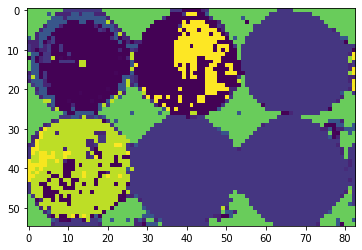

In [255]:
plt.imshow(label0)

#### $NODE$

In [256]:
class Node():
     def __init__(self, name, displ_name = None, internal = None, parent = None, children = None):
            self.parent = parent
            self.name = name
            self.displ_name = displ_name
            if internal:
                self.internal = internal
            if children:
                self.children = children

#### making unique ID

In [257]:
#global names
#names = [0]

In [258]:
def id_n(names):
    names.append(names[len(names)-1]+1)
    return names[len(names)-1]

#### $Algorithm$

In [259]:
def pr_names(band):
    if (band <= 6):
        return "".join(["band0",str(band+1)])
    else:
        return "band10"

In [260]:
def thr_sig(array, bands, x, label, alpha, q):
    m_sig = -100
    r_subs = []
    new_node = []
    arr_f = np.unique(bands[x])
    for F in arr_f:
        subs = subgraph(array, bands, x, F)
        if (find_size(subs[0]) != 0 and find_size(subs[1]) != 0):
            sig = SIG(array, bands, x, F, label, alpha, subs)
            if (sig >= m_sig):
                m_sig = sig
                r_subs = subs
                new_node = [x, F]
    q.put((m_sig, r_subs, new_node))

In [261]:
def SDT_train(array_set, bands_set, label_set, alpha, names, binmask, fl): #flag == amout compression images, if fl == 0 |=> no comression
    
    array = array_set[fl]
    bands = bands_set[fl]
    label = label_set[fl]
    if (array.shape[0]*array.shape[1] < label.shape[0]*label.shape[1]):
        array = array_set[fl]
        bands = bands_set[fl]
        label = label_set[1]
        
    
    print("ВХОД В АЛГОРИТМ:", find_size(array), "С флагом =", fl)
    ch = check_class(array, label)
    if (ch[0]):
        cl = ch[1]
        print(cl)
        if (fl == 0 or cl != -999):
            name = "".join(["class = ", str(cl)])
            leaf = Node(id_n(names), name)
            creating_mask(array, cl, binmask, fl)
            print("Кол-во элементов != None:", find_size(array), "class = ", cl, sep="\t")
            return leaf
        else:
            fl -= 1
            print("DATA COMPRESSION class")
            arr = reverse_comp(array_set[fl+1], array_set[fl], 3)
            array_set[fl] = arr
            SDT_train(array_set, bands_set, label_set, alpha, names, binmask, fl)
            
    elif (find_size(array) <= c0):
        if (fl > 0):
            fl -= 1
            print("DATA COMPRESSION size")
            arr = reverse_comp(array_set[fl+1], array_set[fl], 3)
            array_set[fl] = arr
            SDT_train(array_set, bands_set, label_set, alpha, names, binmask, fl) #дописать binmask 
        else:
            name = "".join(["size <= ",str(c0)])
            leaf = Node(id_n(names), name) #создали лист с классом
            creating_mask(array, None, binmask, fl)
            print("Кол-во элементов != None:", find_size(array), sep="\t")
            return leaf
    
    processes = []
    q = Queue()
    rets = []
    for x in  bands:
        p = Process(target=thr_sig, args=[array, bands, x, label, alpha, q])
        p.start()
        processes.append(p)
        
    for p in processes:
        ret = q.get() 
        rets.append(ret)
    
    for p in processes:
        p.join()
        p.close()
        
    del q
    del processes
    
    m_sig = -100
    tree_split = ()
    item = []
    for item in rets:
        if (item[0] > m_sig):
            m_sig = item[0]
            r_subs = item[1]
            new_node = item[2]
    del rets
    
    if item[1]:
        print("Разделение случилось: ", m_sig, find_size(r_subs[0]), find_size(r_subs[1]), fl)
        name = "".join([pr_names(new_node[0]), " ", "F <= ", str(new_node[1])])
        int_node = Node(id_n(names), name)
        if (fl):
            array_set1 = {0:array0, 1:r_subs[0]}
            array_set2 = {0:array0, 1:r_subs[1]}
        else:
            array_set1 = {0:r_subs[0], 1:array1}
            array_set2 = {0:r_subs[1], 1:array1}
        int_node.children = [SDT_train(array_set1, bands_set, label_set, alpha, names, binmask, fl), SDT_train(array_set2, bands_set, label_set, alpha, names, binmask, fl)]
        return int_node
    else:
        if (fl >= 1):
            fl -= 1
            print("DATA COMPRESSION")
            arr = reverse_comp(array_set[fl+1], array_set[fl], 3)
            array_set[fl] = arr
            name = "DATA COMPRESSION"
            #int_node = Node(id_n(names), name)
            #int_node.children = [SDT_train(array_set, bands_set, label_set, alpha, names, binmask, fl)] #дописать binmask 
            SDT_train(array_set, bands_set, label_set, alpha, names, binmask, fl)
        else:
            name = "".join(["size <= ",str(c0)])
            leaf = Node(id_n(names), name) #создали лист с классом
            creating_mask(array, None, binmask, fl)
            print("Кол-во элементов != None не смогли разбить:", find_size(array), sep="\t")
            return Node(leaf)

### Тестовые данные с парамтером балансировки 0.1

In [262]:
def percent_error(binmask, label):
    right = np.sum(label == binmask)
    ans = right/(label.shape[0]*label.shape[1])
    return ans  

In [267]:
array1 = MoransI(array0, 3, 0.0, 1)

(57, 84)
Mor= 1 176.0 1
Mor= -0.003525510330170038 163.22222222222223 1
Mor= 0.16302233351423512 103.88888888888889 1
Mor= 0.01114707662860122 40.333333333333336 1
Mor= 0.045154986981663675 48.55555555555556 1
Mor= 0.10832454416351392 48.55555555555556 1
Mor= 0.05154754798756278 84.22222222222223 1
Mor= 1 176.0 1
Mor= 1 176.0 1
Mor= 1 176.0 1
Mor= 1 176.0 1
Mor= 0.11898597364323843 141.0 1
Mor= 0.2820408264136022 12.666666666666666 1
Mor= 0.14433170911255516 55.333333333333336 1
Mor= -0.00793630995802051 28.77777777777778 1
Mor= 0.014898003184360655 112.66666666666667 1
Mor= 1 176.0 1
Mor= 1 176.0 1
Mor= -0.0035255103301700375 163.22222222222223 1
Mor= 1 176.0 1
Mor= 0.18050612890470535 98.22222222222223 1
Mor= 1 36.0 1
Mor= 0.17325365051121275 67.11111111111111 1
Mor= 0.28204082641360223 82.66666666666667 1
Mor= 0.11886006256001806 144.88888888888889 1
Mor= 1 176.0 1
Mor= 1 176.0 1
Mor= -0.02820408264136023 -215.66666666666666 1
Mor= 1 176.0 1
Mor= 0.06337098986011444 91.1111111111111

Mor= 0.16403343826622863 170.22222222222223 1
Mor= 0.28781233124747074 151.44444444444446 1
Mor= 0.07566441746870468 125.55555555555556 1
Mor= -0.04026793830241078 147.66666666666666 1
Mor= 1 176.0 1
Mor= 1 176.0 1
Mor= -0.00352551033017005 160.44444444444446 1
Mor= 0.07051020660340053 82.66666666666667 1
Mor= 1 36.0 1
Mor= 0.05756579554038819 31.11111111111111 1
Mor= -0.035255103301700265 34.666666666666664 1
Mor= 0.07051020660340056 129.33333333333334 1
Mor= 1 176.0 1
Mor= 1 176.0 1
Mor= 1 176.0 1
Mor= -0.0035255103301700336 159.11111111111111 1
Mor= 0.18050612890470535 98.22222222222223 1
Mor= 1 36.0 1
Mor= 1 36.0 1
Mor= 0.28204082641360223 82.66666666666667 1
Mor= 0.11886006256001806 144.88888888888889 1
Mor= 0.08591805663309879 113.55555555555556 1
Mor= 0.09275404131655689 120.77777777777777 1
Mor= -0.02256844641427363 -228.44444444444446 1
Mor= 0.07615307882282721 126.66666666666667 1
Mor= -0.07102678264419132 191.55555555555554 1
Mor= -0.035255103301700265 184.88888888888889 1
M

Mor= 0.22563266113088173 -654.0 1
Mor= 0.21507275339589624 -639.7777777777778 1
Mor= 0.22563266113088168 -607.3333333333334 1
Mor= 0.21056810101670795 -639.5555555555555 1
Mor= 0.16922449584816127 -737.8888888888889 1


In [268]:
label1 = MoransI(label0, 3, 0.0, 1)

(57, 84)
Mor= 1 176.0 1
Mor= -0.003525510330170038 163.22222222222223 1
Mor= 0.16302233351423512 103.88888888888889 1
Mor= 0.01114707662860122 40.333333333333336 1
Mor= 0.045154986981663675 48.55555555555556 1
Mor= 0.10832454416351392 48.55555555555556 1
Mor= 0.05154754798756278 84.22222222222223 1
Mor= 1 176.0 1
Mor= 1 176.0 1
Mor= 1 176.0 1
Mor= 1 176.0 1
Mor= 0.11898597364323843 141.0 1
Mor= 0.2820408264136022 12.666666666666666 1
Mor= 0.14433170911255516 55.333333333333336 1
Mor= -0.00793630995802051 28.77777777777778 1
Mor= 0.014898003184360655 112.66666666666667 1
Mor= 1 176.0 1
Mor= 1 176.0 1
Mor= -0.0035255103301700375 163.22222222222223 1
Mor= 1 176.0 1
Mor= 0.18050612890470535 98.22222222222223 1
Mor= 1 36.0 1
Mor= 0.17325365051121275 67.11111111111111 1
Mor= 0.28204082641360223 82.66666666666667 1
Mor= 0.11886006256001806 144.88888888888889 1
Mor= 1 176.0 1
Mor= 1 176.0 1
Mor= -0.02820408264136023 -215.66666666666666 1
Mor= 1 176.0 1
Mor= 0.06337098986011444 91.1111111111111

Mor= 0.16403343826622863 170.22222222222223 1
Mor= 0.28781233124747074 151.44444444444446 1
Mor= 0.07566441746870468 125.55555555555556 1
Mor= -0.04026793830241078 147.66666666666666 1
Mor= 1 176.0 1
Mor= 1 176.0 1
Mor= -0.00352551033017005 160.44444444444446 1
Mor= 0.07051020660340053 82.66666666666667 1
Mor= 1 36.0 1
Mor= 0.05756579554038819 31.11111111111111 1
Mor= -0.035255103301700265 34.666666666666664 1
Mor= 0.07051020660340056 129.33333333333334 1
Mor= 1 176.0 1
Mor= 1 176.0 1
Mor= 1 176.0 1
Mor= -0.0035255103301700336 159.11111111111111 1
Mor= 0.18050612890470535 98.22222222222223 1
Mor= 1 36.0 1
Mor= 1 36.0 1
Mor= 0.28204082641360223 82.66666666666667 1
Mor= 0.11886006256001806 144.88888888888889 1
Mor= 0.19946174345115178 92.22222222222223 1
Mor= 0.09275404131655689 120.77777777777777 1
Mor= -0.02256844641427363 -228.44444444444446 1
Mor= 0.07615307882282721 126.66666666666667 1
Mor= -0.07102678264419132 191.55555555555554 1
Mor= -0.035255103301700265 184.88888888888889 1
Mo

Mor= 0.21507275339589624 -639.7777777777778 1
Mor= 0.22563266113088168 -607.3333333333334 1
Mor= 0.21056810101670795 -639.5555555555555 1
Mor= 0.16922449584816127 -737.8888888888889 1


In [287]:
import time
start_time = time.time()
binmask = np.full((truth.shape[0]+size[1], truth.shape[1]+size[2]), -999)
alpha = 0.1
names = [0]
array_set = {0:array0, 1: array1}
bands_set = {0:bands0, 1: bands1}
label_set = {0:label0, 1: label1}
r = SDT_train(array_set, bands_set, label_set, alpha, names, binmask, 1)
#er = percent_error(binmask, label)
print("--- %s minutes ---" % str((time.time() - start_time)/60.0))

ВХОД В АЛГОРИТМ: 532 С флагом = 1
Разделение случилось:  0.1851660746659355 414 118 1
ВХОД В АЛГОРИТМ: 414 С флагом = 1
Разделение случилось:  0.34815912312811714 413 1 1
ВХОД В АЛГОРИТМ: 413 С флагом = 1
Разделение случилось:  0.33589521278116324 412 1 1
ВХОД В АЛГОРИТМ: 412 С флагом = 1
Разделение случилось:  0.3378081731511799 411 1 1
ВХОД В АЛГОРИТМ: 411 С флагом = 1
Разделение случилось:  0.33933968968083844 410 1 1
ВХОД В АЛГОРИТМ: 410 С флагом = 1
Разделение случилось:  0.34099100399202387 409 1 1
ВХОД В АЛГОРИТМ: 409 С флагом = 1
Разделение случилось:  0.34277776891319256 408 1 1
ВХОД В АЛГОРИТМ: 408 С флагом = 1
Разделение случилось:  0.34251311371159904 407 1 1
ВХОД В АЛГОРИТМ: 407 С флагом = 1
Разделение случилось:  0.3440991988958274 406 1 1
ВХОД В АЛГОРИТМ: 406 С флагом = 1
Разделение случилось:  0.3464313434457889 405 1 1
ВХОД В АЛГОРИТМ: 405 С флагом = 1
Разделение случилось:  0.34814674844625604 404 1 1
ВХОД В АЛГОРИТМ: 404 С флагом = 1
Разделение случилось:  0.34984063

Разделение случилось:  0.47363832318663696 317 1 1
ВХОД В АЛГОРИТМ: 317 С флагом = 1
Разделение случилось:  0.47435594738004955 316 1 1
ВХОД В АЛГОРИТМ: 316 С флагом = 1
Разделение случилось:  0.4755522025981268 315 1 1
ВХОД В АЛГОРИТМ: 315 С флагом = 1
Разделение случилось:  0.4767414999008138 314 1 1
ВХОД В АЛГОРИТМ: 314 С флагом = 1
Разделение случилось:  0.4746818534280627 313 1 1
ВХОД В АЛГОРИТМ: 313 С флагом = 1
Разделение случилось:  0.4755114844157998 312 1 1
ВХОД В АЛГОРИТМ: 312 С флагом = 1
Разделение случилось:  0.47645871486746455 311 1 1
ВХОД В АЛГОРИТМ: 311 С флагом = 1
Разделение случилось:  0.48433493607036304 310 1 1
ВХОД В АЛГОРИТМ: 310 С флагом = 1
Разделение случилось:  0.4819782066712989 309 1 1
ВХОД В АЛГОРИТМ: 309 С флагом = 1
Разделение случилось:  0.4796055870243362 308 1 1
ВХОД В АЛГОРИТМ: 308 С флагом = 1
Разделение случилось:  0.48382263607530285 307 1 1
ВХОД В АЛГОРИТМ: 307 С флагом = 1
Разделение случилось:  0.48482651076961547 306 1 1
ВХОД В АЛГОРИТМ: 306

Разделение случилось:  0.5493849653482152 219 1 1
ВХОД В АЛГОРИТМ: 219 С флагом = 1
Разделение случилось:  0.544857220104243 218 1 1
ВХОД В АЛГОРИТМ: 218 С флагом = 1
Разделение случилось:  0.544967042758198 217 1 1
ВХОД В АЛГОРИТМ: 217 С флагом = 1
Разделение случилось:  0.5456923228751116 216 1 1
ВХОД В АЛГОРИТМ: 216 С флагом = 1
Разделение случилось:  0.5457485486442104 215 1 1
ВХОД В АЛГОРИТМ: 215 С флагом = 1
Разделение случилось:  0.5535679383279348 214 1 1
ВХОД В АЛГОРИТМ: 214 С флагом = 1
Разделение случилось:  0.5503418431381273 213 1 1
ВХОД В АЛГОРИТМ: 213 С флагом = 1
Разделение случилось:  0.5465987075049675 212 1 1
ВХОД В АЛГОРИТМ: 212 С флагом = 1
Разделение случилось:  0.5473300884380492 211 1 1
ВХОД В АЛГОРИТМ: 211 С флагом = 1
Разделение случилось:  0.5478934045473388 210 1 1
ВХОД В АЛГОРИТМ: 210 С флагом = 1
Разделение случилось:  0.5477246925346089 209 1 1
ВХОД В АЛГОРИТМ: 209 С флагом = 1
Разделение случилось:  0.5520168954021961 208 1 1
ВХОД В АЛГОРИТМ: 208 С флаго

Разделение случилось:  0.5175931315768826 120 1 1
ВХОД В АЛГОРИТМ: 120 С флагом = 1
Разделение случилось:  0.5085173981418014 119 1 1
ВХОД В АЛГОРИТМ: 119 С флагом = 1
Разделение случилось:  0.515863378740879 118 1 1
ВХОД В АЛГОРИТМ: 118 С флагом = 1
Разделение случилось:  0.5127455919425675 117 1 1
ВХОД В АЛГОРИТМ: 117 С флагом = 1
Разделение случилось:  0.5120114479615812 116 1 1
ВХОД В АЛГОРИТМ: 116 С флагом = 1
Разделение случилось:  0.5044825858072483 115 1 1
ВХОД В АЛГОРИТМ: 115 С флагом = 1
Разделение случилось:  0.5028802550280128 114 1 1
ВХОД В АЛГОРИТМ: 114 С флагом = 1
Разделение случилось:  0.5109786707942123 113 1 1
ВХОД В АЛГОРИТМ: 113 С флагом = 1
Разделение случилось:  0.5003381974269796 112 1 1
ВХОД В АЛГОРИТМ: 112 С флагом = 1
Разделение случилось:  0.5063990499858713 111 1 1
ВХОД В АЛГОРИТМ: 111 С флагом = 1
Разделение случилось:  0.5055835300202969 110 1 1
ВХОД В АЛГОРИТМ: 110 С флагом = 1
Разделение случилось:  0.5047770961243242 109 1 1
ВХОД В АЛГОРИТМ: 109 С флаг

Разделение случилось:  0.27370767422641606 198 1 0
ВХОД В АЛГОРИТМ: 198 С флагом = 0
Разделение случилось:  0.27295922828664687 197 1 0
ВХОД В АЛГОРИТМ: 197 С флагом = 0
Разделение случилось:  0.27274091934401234 196 1 0
ВХОД В АЛГОРИТМ: 196 С флагом = 0
Разделение случилось:  0.2714171310029635 195 1 0
ВХОД В АЛГОРИТМ: 195 С флагом = 0
Разделение случилось:  0.2712700842147382 194 1 0
ВХОД В АЛГОРИТМ: 194 С флагом = 0
Разделение случилось:  0.27003920710223733 193 1 0
ВХОД В АЛГОРИТМ: 193 С флагом = 0
Разделение случилось:  0.26955651352964094 192 1 0
ВХОД В АЛГОРИТМ: 192 С флагом = 0
Разделение случилось:  0.26895164015934503 191 1 0
ВХОД В АЛГОРИТМ: 191 С флагом = 0
Разделение случилось:  0.2683380829684026 190 1 0
ВХОД В АЛГОРИТМ: 190 С флагом = 0
Разделение случилось:  0.2677121874431854 189 1 0
ВХОД В АЛГОРИТМ: 189 С флагом = 0
Разделение случилось:  0.2674313099403593 188 1 0
ВХОД В АЛГОРИТМ: 188 С флагом = 0
Разделение случилось:  0.26649411237756704 187 1 0
ВХОД В АЛГОРИТМ: 18

Разделение случилось:  0.20753421846404693 101 1 0
ВХОД В АЛГОРИТМ: 101 С флагом = 0
Разделение случилось:  0.20601188234892914 100 1 0
ВХОД В АЛГОРИТМ: 100 С флагом = 0
Разделение случилось:  0.2052350896369733 99 1 0
ВХОД В АЛГОРИТМ: 99 С флагом = 0
Разделение случилось:  0.20530685111057542 98 1 0
ВХОД В АЛГОРИТМ: 98 С флагом = 0
Разделение случилось:  0.20399377691935164 97 1 0
ВХОД В АЛГОРИТМ: 97 С флагом = 0
Разделение случилось:  0.20278948426419408 96 1 0
ВХОД В АЛГОРИТМ: 96 С флагом = 0
Разделение случилось:  0.20204502771664484 95 1 0
ВХОД В АЛГОРИТМ: 95 С флагом = 0
Разделение случилось:  0.20123196292981216 94 1 0
ВХОД В АЛГОРИТМ: 94 С флагом = 0
Разделение случилось:  0.20048169692972745 93 1 0
ВХОД В АЛГОРИТМ: 93 С флагом = 0
Разделение случилось:  0.20014373102787458 92 1 0
ВХОД В АЛГОРИТМ: 92 С флагом = 0
Разделение случилось:  0.19992264043288957 91 1 0
ВХОД В АЛГОРИТМ: 91 С флагом = 0
Разделение случилось:  0.19808454033827577 90 1 0
ВХОД В АЛГОРИТМ: 90 С флагом = 0
Р

Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
205
Кол-во элементов != None:	1	class = 	205
ВХОД В АЛГОРИТМ: 1 С флагом = 0
225
Кол-во элементов != None:	1	class = 	225
ВХОД В АЛГОРИТМ: 1 С флагом = 0
1
Кол-во элементов != None:	1	class = 	1
ВХОД В АЛГОРИТМ: 1 С флагом = 0
205
Кол-во элементов != None:	1	class = 	205
ВХОД В АЛГОРИТМ: 1 С флагом = 0
225
Кол-во элементов != None:	1	class = 	225
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
228
Кол-во элементов != None:	1	class = 	228
ВХОД В АЛГОРИТМ: 1 С флагом = 0
225
Кол-во элементов != None:	1	class = 	225
ВХОД В АЛГОРИТМ: 1 С флагом = 0
228
Кол-во элементов != None:	1	class = 	228
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
190
Кол-во 

36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	class = 	24
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	class = 	24
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	class = 	24
ВХОД В АЛГОРИТМ: 1 С флагом = 0
1
Кол-во элементов != None:	1	class = 	1
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	class = 	24
ВХОД В АЛГОРИТМ: 1 С флагом = 0
61
Кол-во элементов != None:	1	class = 	61
ВХОД В АЛГОРИТМ: 1 С флагом = 0
1
Кол-во элементов != None:	1	class = 	1
ВХОД В АЛГОРИТМ: 1 С флагом = 0
1
Кол-во элементов != None:	1

Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.11422307804682563 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
205
Кол-во элементов != None:	8	class = 	205
ВХОД В АЛГОРИТМ: 1 С флагом = 0
1
Кол-во элементов != None:	1	class = 	1
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.11359905254255549 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.11210961005426524 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.11069179996327959 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
Разделение случилось:  0.10919091843530483 5 1 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
Кол-во элементов != None:	5
ВХОД В АЛГОРИТМ: 1 С флагом = 0
1
Кол-во элементов != None:	1	class = 	1
ВХОД В АЛГОРИТМ: 1 С флагом = 0
1
Кол-во элементов != None:	1	class = 	1
ВХОД В АЛГОРИТМ: 1 С флагом

Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
205
Кол-во элементов != None:	1	class = 	205
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.11346129524177223 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.1127493912696109 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.11041489839519912 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
Разделение случилось:  0.10956331712095653 5 1 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
205
Кол-во элементов != None:	5	class = 	205
ВХОД В АЛГОРИТМ: 1 С флагом = 0
225
Кол-во элементов != None:	1	class = 	225
ВХОД В АЛГОРИТМ: 1 С флагом = 0
205
Кол-во элементов != None:	1	class = 	205
ВХОД В АЛГОРИТМ: 1 С флагом = 0
1
Кол-во элементов != None:	1	class = 	1
ВХОД В АЛГОРИТМ: 1 С флагом = 0
205
Кол-во элементов != None:	1	class = 	205
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
205
Кол-во элементов != None:	1	cla

Разделение случилось:  0.11277129707464924 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.11065894125572209 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
Разделение случилось:  0.1091690126302665 5 1 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
Кол-во элементов != None:	5
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	class = 	24
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.11428879546194061 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.1123112751688442 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.11116921480488903 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
205
Кол-во элементов != None:	6	class = 	205
ВХО

Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 2 С флагом = 1
176
Кол-во элементов != None:	2	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 1
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 1
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 1
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 1
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.11391639677628893 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.1128151086847259 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.11045871000527578 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
Разделение случилось:  0.10888817807159694 5 1 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
Кол-во элементов != None:	5
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементо

Разделение случилось:  0.12337874314818546 15 1 0
ВХОД В АЛГОРИТМ: 15 С флагом = 0
Разделение случилось:  0.12208791765737488 14 1 0
ВХОД В АЛГОРИТМ: 14 С флагом = 0
Разделение случилось:  0.12087821016716499 13 1 0
ВХОД В АЛГОРИТМ: 13 С флагом = 0
Разделение случилось:  0.11962211027767619 12 1 0
ВХОД В АЛГОРИТМ: 12 С флагом = 0
Разделение случилось:  0.11866442738698378 11 1 0
ВХОД В АЛГОРИТМ: 11 С флагом = 0
Разделение случилось:  0.11722082954554698 10 1 0
ВХОД В АЛГОРИТМ: 10 С флагом = 0
Разделение случилось:  0.11574874106541605 9 1 0
ВХОД В АЛГОРИТМ: 9 С флагом = 0
1
Кол-во элементов != None:	9	class = 	1
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	class = 	24
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176

Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.11369089869262033 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.11233318097388253 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.11040759646018634 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
Разделение случилось:  0.10884071549401389 5 1 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
Кол-во элементов != None:	5
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГ

Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.11347589911179778 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.11233318097388253 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.11037473775262886 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
Разделение случилось:  0.10881880968897556 5 1 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
Кол-во элементов != None:	5
ВХОД В АЛГОРИТМ: 1 С флагом = 0
1
Кол-во элементов != None:	1	class = 	1
ВХОД В АЛГОРИТМ: 1 С флагом = 0
1
Кол-во элементов != None:	1	class = 	1
ВХОД В АЛГОРИТМ: 1 С флагом = 0
43
Кол-во элементов != None:	1	class = 	43
ВХОД В АЛГОРИТМ: 1 С флагом = 0
1
Кол-во элементов != None:	1	cl

Разделение случилось:  0.11431070126697897 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.11237699258395921 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.11123493222000404 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
Разделение случилось:  0.10960712873103319 5 1 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
176
Кол-во элементов != None:	5	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
1
Кол-во элементов != None:	1	class = 	1
ВХОД В АЛГОРИТМ: 1 С флагом = 0
205
Кол-во элементов != None:	1	class = 	205
ВХОД В АЛГОРИТМ: 1 С флагом = 0
1
Кол-во элементов != None:	1	class = 	1
ВХОД В АЛГОРИТМ: 1 С флагом = 0
61
Кол-во элементов != None:	1	class = 	61
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 1
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.11426688965690228 

Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.11389449097125058 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.11277129707464924 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.11079681611923735 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
Разделение случилось:  0.10958522292599486 5 1 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
176
Кол-во элементов != None:	5	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	class = 	24
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	class = 	24
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	

Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 1
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.11387258516621225 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.11233318097388253 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.11121302641496571 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
Разделение случилось:  0.10958522292599486 5 1 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
Кол-во элементов != None:	5
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	class = 	24
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	class = 	24
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОР

Разделение случилось:  0.11357234392896082 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.11215149450029062 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.11041740543789527 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
Разделение случилось:  0.1088797242955342 5 1 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
Кол-во элементов != None:	5
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
1
Кол-во элементов != None:	1	class = 	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.11348336550716126 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.11202678964266827 7 1 0
ВХОД

Разделение случилось:  0.10885531936403946 5 1 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
Кол-во элементов != None:	5
ВХОД В АЛГОРИТМ: 1 С флагом = 0
1
Кол-во элементов != None:	1	class = 	1
ВХОД В АЛГОРИТМ: 1 С флагом = 0
1
Кол-во элементов != None:	1	class = 	1
ВХОД В АЛГОРИТМ: 1 С флагом = 0
205
Кол-во элементов != None:	1	class = 	205
ВХОД В АЛГОРИТМ: 1 С флагом = 0
4
Кол-во элементов != None:	1	class = 	4
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.113734710302697 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.11235508677892087 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.11075300450916067 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
Разделение случилось:  0.10956331712095653 5 1 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
Кол-во элементов != None:	5
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	class = 	24
ВХОД В АЛГОРИТМ: 1 С флагом = 0


Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.11335845650808074 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.11187442847185947 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.1103564829150969 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
Разделение случилось:  0.10882246065648196 5 1 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
Кол-во элементов != None:	5
ВХОД В АЛГОРИТМ: 1 С флагом = 0
1
Кол-во элементов != None:	1	class = 	1
ВХОД В АЛГОРИТМ: 1 С флагом = 0
1
Кол-во элементов != None:	1	class = 	1
ВХОД В АЛГОРИТМ: 1 С флагом = 0
1
Кол-во элементов != None:	1	class = 	1
ВХОД В АЛГОРИТМ: 1 С флагом = 0
1
Кол-во элементов != None:	1	class = 	1
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.11431070126697895 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0


Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.11435451287705561 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.1128151086847259 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.11069179996327959 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
Разделение случилось:  0.1091690126302665 5 1 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
Кол-во элементов != None:	5
ВХОД В АЛГОРИТМ: 1 С флагом = 0
61
Кол-во элементов != None:	1	class = 	61
ВХОД В АЛГОРИТМ: 1 С флагом = 0
61
Кол-во элементов != None:	1	class = 	61
ВХОД В АЛГОРИТМ: 1 С флагом = 0
28
Кол-во элементов != None:	1	class = 	28
ВХОД В АЛГОРИТМ: 1 С флагом = 0
205
Кол-во элементов != None:	1	class = 	205
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.11372375740017783 8 1 0
ВХОД В АЛГОРИТМ: 8 С фл

Разделение случилось:  0.11437641868209396 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.11206809421004878 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.11054884026812528 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
Разделение случилось:  0.1092347300453815 5 1 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
Кол-во элементов != None:	5
ВХОД В АЛГОРИТМ: 1 С флагом = 0
61
Кол-во элементов != None:	1	class = 	61
ВХОД В АЛГОРИТМ: 1 С флагом = 0
1
Кол-во элементов != None:	1	class = 	1
ВХОД В АЛГОРИТМ: 1 С флагом = 0
1
Кол-во элементов != None:	1	class = 	1
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	class = 	24
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.11385067936117392 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.11192189104944252 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.11041124742769273 6 1 0
ВХОД

Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.11382877355613559 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.1118963342768978 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.11037108678512245 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
Разделение случилось:  0.10879690388393723 5 1 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
Кол-во элемент

Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.11426688965690228 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.1123112751688442 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.11116921480488903 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
Разделение случилось:  0.10912520102018983 5 1 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
Кол-во элементов != None:	5
ВХОД В АЛГОРИТМ: 1 С флагом = 0
61
Кол-во элементов != None:	1	class = 	61
ВХОД В АЛГОРИТМ: 1 С флагом = 0
0
Кол-во элементов != None:	1	class = 	0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
0
Кол-во элементов != None:	1	class = 	0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
4
Кол-во элементов != None:	1	class = 	4
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.11435451287705561 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 

Разделение случилось:  0.11368187295415247 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.11223911772044395 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.11086253353435235 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
Разделение случилось:  0.10967284614614821 5 1 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
1
Кол-во элементов != None:	5	class = 	1
ВХОД В АЛГОРИТМ: 1 С флагом = 0
228
Кол-во элементов != None:	1	class = 	228
ВХОД В АЛГОРИТМ: 1 С флагом = 0
228
Кол-во элементов != None:	1	class = 	228
ВХОД В АЛГОРИТМ: 1 С флагом = 0
228
Кол-во элементов != None:	1	class = 	228
ВХОД В АЛГОРИТМ: 1 С флагом = 0
228
Кол-во элементов != None:	1	class = 	228
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.11344607972823408 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.11196935362702558 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.11

Разделение случилось:  0.4576412972701661 83 1 1
ВХОД В АЛГОРИТМ: 83 С флагом = 1
Разделение случилось:  0.4565015728355375 82 1 1
ВХОД В АЛГОРИТМ: 82 С флагом = 1
Разделение случилось:  0.46272461140746 81 1 1
ВХОД В АЛГОРИТМ: 81 С флагом = 1
Разделение случилось:  0.4560783964248606 80 1 1
ВХОД В АЛГОРИТМ: 80 С флагом = 1
Разделение случилось:  0.45135250620742207 79 1 1
ВХОД В АЛГОРИТМ: 79 С флагом = 1
Разделение случилось:  0.44929522415368456 78 1 1
ВХОД В АЛГОРИТМ: 78 С флагом = 1
Разделение случилось:  0.44799267904024864 77 1 1
ВХОД В АЛГОРИТМ: 77 С флагом = 1
Разделение случилось:  0.4466084423738238 76 1 1
ВХОД В АЛГОРИТМ: 76 С флагом = 1
Разделение случилось:  0.43825074679261916 75 1 1
ВХОД В АЛГОРИТМ: 75 С флагом = 1
Разделение случилось:  0.43584621430095893 74 1 1
ВХОД В АЛГОРИТМ: 74 С флагом = 1
Разделение случилось:  0.4401167298871965 73 1 1
ВХОД В АЛГОРИТМ: 73 С флагом = 1
Разделение случилось:  0.4316694509625104 72 1 1
ВХОД В АЛГОРИТМ: 72 С флагом = 1
Разделение сл

Разделение случилось:  0.11345764427426584 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.11197316905488265 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.11047947188550392 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
Разделение случилось:  0.1089125830030917 5 1 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
Кол-во элементов != None:	5
ВХОД В АЛГОРИТМ: 1 С флагом = 0
1
Кол-во элементов != None:	1	class = 	1
ВХОД В АЛГОРИТМ: 1 С флагом = 0
1
Кол-во элементов != None:	1	class = 	1
ВХОД В АЛГОРИТМ: 1 С флагом = 0
1
Кол-во элементов != None:	1	class = 	1
ВХОД В АЛГОРИТМ: 1 С флагом = 0
1
Кол-во элементов != None:	1	class = 	1
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 1
1
Кол-во элементов != None:	1	class = 	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИ

Разделение случилось:  0.11198030652954476 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.1104550590377694 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
Разделение случилось:  0.10892103677915446 5 1 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
Кол-во элементов != None:	5
ВХОД В АЛГОРИТМ: 1 С флагом = 0
228
Кол-во элементов != None:	1	class = 	228
ВХОД В АЛГОРИТМ: 1 С флагом = 0
228
Кол-во элементов != None:	1	class = 	228
ВХОД В АЛГОРИТМ: 1 С флагом = 0
228
Кол-во элементов != None:	1	class = 	228
ВХОД В АЛГОРИТМ: 1 С флагом = 0
1
Кол-во элементов != None:	1	class = 	1
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.11393830258132726 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.1128151086847259 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
1
Кол-во элементов != None:	7	class = 	1
ВХОД В АЛГОРИТМ: 1 С флагом = 0
228
Кол-во элементов != None:	1	class = 	228
ВХОД В АЛ

Разделение случилось:  0.11036013388260328 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
Разделение случилось:  0.1088078567864564 5 1 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
Кол-во элементов != None:	5
ВХОД В АЛГОРИТМ: 1 С флагом = 0
228
Кол-во элементов != None:	1	class = 	228
ВХОД В АЛГОРИТМ: 1 С флагом = 0
228
Кол-во элементов != None:	1	class = 	228
ВХОД В АЛГОРИТМ: 1 С флагом = 0
228
Кол-во элементов != None:	1	class = 	228
ВХОД В АЛГОРИТМ: 1 С флагом = 0
1
Кол-во элементов != None:	1	class = 	1
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
1
Кол-во элементов != None:	1	class = 	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.11364708708254366 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.11226746355876753 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.11116921480488903 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
228
Кол-во элементов != None:	6	class = 	228
ВХОД В А

Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.11387258516621225 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.11201583674014909 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.11119112060992738 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
Разделение случилось:  0.10958522292599486 5 1 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
Кол-во элементов != None:	5
ВХОД В АЛГОРИТМ: 1 С флагом = 0
205
Кол-во элементов != None:	1	class = 	205
ВХОД В АЛГОРИТМ: 1 С флагом = 0
61
Кол-во элементов != None:	1	class = 	61
ВХОД В АЛГОРИТМ: 1 С флагом = 0
1
Кол-во элементов != None:	1	class = 	1
ВХОД В АЛГОРИТМ: 1 С флагом = 0
61
Кол-во элементов != None:	1	class = 	61
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
1
Кол-во элементов != None:	1	class = 	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
1
Кол-во элементов != None:	1	class = 	1
ВХОД В АЛГОРИТМ: 1

### Визуализация полученных данных

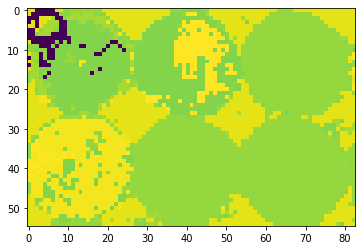

In [341]:
plt.imshow(binmask)

In [342]:
print(percent_error(binmask, label0))

0.9472070098576123


Процент правильности классификации $\approx 95\%$ 

In [364]:
unique, counts = np.unique(label0, return_counts=True)
un = dict(zip(unique, counts))
unique, counts = np.unique(binmask, return_counts=True)
unbin = dict(zip(unique, counts))

In [396]:
lab = []
percent = []
for x in un:
    if (x != 43):
        lab.append(int(x))
        percent.append(unbin[x]/un[x])
    else:
        lab.append(int(x))
        percent.append(0)

In [397]:
data_lab = np.array([lab, percent])
ind = ["label", "correct per."]
df1 = pd.DataFrame(data=data_lab, index = ind)
df1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
label,0.0,1.000000,4.000000,24.000000,28.0,29.0,36.000000,43.0,61.000000,176.000000,190.0,205.000000,225.00000,228.000000
correct per.,1.0,0.966184,0.954545,0.839416,1.0,1.0,0.996886,0.0,0.836478,0.974638,1.0,1.054245,0.93617,1.011173


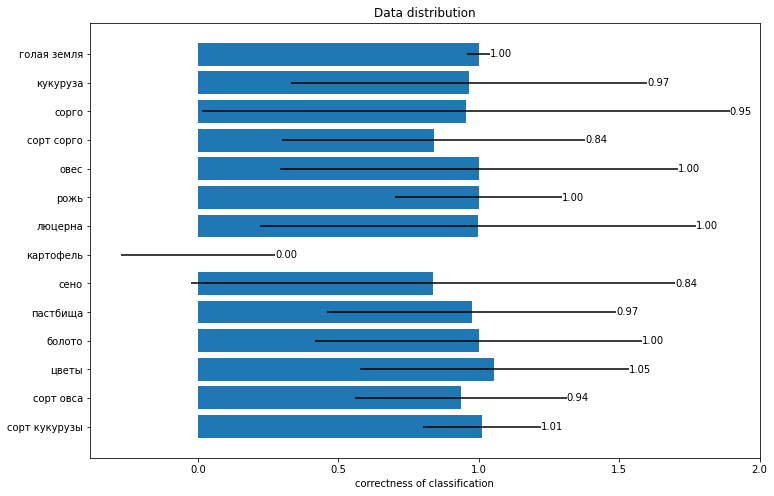

In [415]:
label = ('голая земля', 'кукуруза', 'сорго', 'сорт сорго', 'овес', 'рожь', 'люцерна', 'картофель', 'сено', 'пастбища', 'болото', 'цветы', 'сорт овса', 'сорт кукурузы')
y_pos = np.arange(len(people))
performance = percent
error = np.random.rand(len(people))

fig, ax = plt.subplots(figsize=(12,8))

hbars = ax.barh(y_pos, performance, xerr=error, align='center')
ax.set_yticks(y_pos, labels=label)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('correctness of classification')
ax.set_title('Data distribution')

# Label with specially formatted floats
ax.bar_label(hbars, fmt='%.2f')
ax.set_xlim(right=2)  # adjust xlim to fit labels

plt.show()

### Поиск параметра балансировки

In [166]:
def finding_alpha():
    alpha = 0.0
    x1 = []
    y1 = []
    m_er = -1
    true_mask1 = []
    while alpha <= 1.0:
        print("alpha =", alpha)
        names = [0]
        binmask = np.full((truth.shape[0]+size[1], truth.shape[1]+size[2]), -999)
        array_set = {0:array0, 1: array1}
        bands_set = {0:bands0, 1: bands1}
        label_set = {0:label0, 1: label1}
        r = SDT_train(array_set, bands_set, label_set, alpha, names, binmask, 1)
        x1.append(alpha)
        binmask = np.delete(binmask, (binmask.shape[1]-1, binmask.shape[1]-2), 1)
        true_mask1.append(binmask)
        y1.append(percent_error(binmask, label0))
        print("\nКорректность выполнения алгоритма ==", percent_error(binmask, label0), "при альфа =", alpha,"\n")
        alpha += 0.1
        alpha = round(alpha, 1)
    return (x1, y1,  true_mask1)

In [167]:
import time
start_time = time.time()
a = finding_alpha()
print("--- %s minutes ---" % str((time.time() - start_time)/60.0))

alpha = 0.0
ВХОД В АЛГОРИТМ: 171 С флагом = 1
Разделение случилось:  0.3151189015347837 130 41 1
ВХОД В АЛГОРИТМ: 130 С флагом = 1
Разделение случилось:  0.3360719147705411 128 2 1
ВХОД В АЛГОРИТМ: 128 С флагом = 1
Разделение случилось:  0.28505219666049453 127 1 1
ВХОД В АЛГОРИТМ: 127 С флагом = 1
Разделение случилось:  0.29086592585611104 126 1 1
ВХОД В АЛГОРИТМ: 126 С флагом = 1
Разделение случилось:  0.30187316340911274 125 1 1
ВХОД В АЛГОРИТМ: 125 С флагом = 1
Разделение случилось:  0.30219616249453585 124 1 1
ВХОД В АЛГОРИТМ: 124 С флагом = 1
Разделение случилось:  0.3078222950745898 123 1 1
ВХОД В АЛГОРИТМ: 123 С флагом = 1
Разделение случилось:  0.31862431020065085 122 1 1
ВХОД В АЛГОРИТМ: 122 С флагом = 1
Разделение случилось:  0.318768085717999 121 1 1
ВХОД В АЛГОРИТМ: 121 С флагом = 1
Разделение случилось:  0.3242003788994452 120 1 1
ВХОД В АЛГОРИТМ: 120 С флагом = 1
Разделение случилось:  0.33479010064181247 119 1 1
ВХОД В АЛГОРИТМ: 119 С флагом = 1
Разделение случилось:  0

Разделение случилось:  0.042465021979800364 9 1 0
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.03874941638266996 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.034006344944457124 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.03213033614033057 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
Разделение случилось:  0.025475655798881565 5 1 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
Кол-во элементов != None:	5
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	class = 	24
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
205
Кол-во элементов != None:	1	class = 	205
ВХОД В АЛГОРИТМ: 1 С флагом = 0
205
Кол-во элементов != None:	1	class = 	205
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
205

Разделение случилось:  0.03874941638266996 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.035090277923875854 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.03213033614033056 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
205
Кол-во элементов != None:	6	class = 	205
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	class = 	24
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	class = 	24
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	class = 	24
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.03767626618507178 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.0364370792706772 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
205
Кол-во элементов != None:	7	class

Разделение случилось:  0.36495576917775796 24 1 1
ВХОД В АЛГОРИТМ: 24 С флагом = 1
Разделение случилось:  0.35701253134504196 23 1 1
ВХОД В АЛГОРИТМ: 23 С флагом = 1
Разделение случилось:  0.3487249765054178 22 1 1
ВХОД В АЛГОРИТМ: 22 С флагом = 1
Разделение случилось:  0.3400788832393804 21 1 1
ВХОД В АЛГОРИТМ: 21 С флагом = 1
Разделение случилось:  0.331058876457753 20 1 1
ВХОД В АЛГОРИТМ: 20 С флагом = 1
Разделение случилось:  0.32164829802908784 19 1 1
ВХОД В АЛГОРИТМ: 19 С флагом = 1
Разделение случилось:  0.3428254965741391 18 1 1
ВХОД В АЛГОРИТМ: 18 С флагом = 1
Разделение случилось:  0.3009783649162232 17 1 1
ВХОД В АЛГОРИТМ: 17 С флагом = 1
Разделение случилось:  0.2902345951743495 16 1 1
ВХОД В АЛГОРИТМ: 16 С флагом = 1
Разделение случилось:  0.2790100161286785 15 1 1
ВХОД В АЛГОРИТМ: 15 С флагом = 1
Разделение случилось:  0.2672771687833145 14 1 1
ВХОД В АЛГОРИТМ: 14 С флагом = 1
Разделение случилось:  0.25500567993131357 13 1 1
ВХОД В АЛГОРИТМ: 13 С флагом = 1
Разделение сл

Разделение случилось:  0.035090277923875854 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.03213033614033056 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
205
Кол-во элементов != None:	6	class = 	205
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.03925775813496859 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.0364370792706772 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
36
Кол-во элементов != None:	7	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
0
Кол-во элементов != None:	1	class = 	0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
0
Кол-во элементов != None:	1	class = 	0
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-

Разделение случилось:  0.039257758134968596 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.034581936171577225 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.030783534793529223 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
Разделение случилось:  0.027660916740185615 5 1 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
Кол-во элементов != None:	5
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
205
Кол-во элементов != None:	1	class = 	205
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.039257758134968596 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.0364370792706772 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.03078353479

Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 1
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.038419298540465885 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.03458193617157722 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.030783534793529216 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
Разделение случилось:  0.027660916740185615 5 1 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
176
Кол-во элементов != None:	5	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
0
Кол-во элементов != None:	1	class = 	0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
0
Кол-во элементов != None:	1	class = 	0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
0
Кол-во элементов != None:	1	class = 	0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
0
Кол-во элементов != None:	1	class = 	0
Кол-во элементов != None не смогли разбить:	

Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.04060455948176994 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.0364370792706772 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.030275193041230587 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
Разделение случилось:  0.026314115393384276 5 1 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
Кол-во элементов != None:	5
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
205
Кол-во элементов != None:	1	class = 	205
ВХОД В АЛГОРИТМ: 1 С флагом = 0
236
Кол-во элементов != None:	1	class = 	236
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.03767626618507178 8 1 0
ВХОД В АЛГОРИТ

Разделение случилось:  0.44556514835256245 105 1 1
ВХОД В АЛГОРИТМ: 105 С флагом = 1
Разделение случилось:  0.4489227618529425 104 1 1
ВХОД В АЛГОРИТМ: 104 С флагом = 1
Разделение случилось:  0.4529902676266713 103 1 1
ВХОД В АЛГОРИТМ: 103 С флагом = 1
Разделение случилось:  0.45635369448867746 102 1 1
ВХОД В АЛГОРИТМ: 102 С флагом = 1
Разделение случилось:  0.4592559814097464 101 1 1
ВХОД В АЛГОРИТМ: 101 С флагом = 1
Разделение случилось:  0.4625248523348827 100 1 1
ВХОД В АЛГОРИТМ: 100 С флагом = 1
Разделение случилось:  0.4650387026976295 99 1 1
ВХОД В АЛГОРИТМ: 99 С флагом = 1
Разделение случилось:  0.47425756965311683 98 1 1
ВХОД В АЛГОРИТМ: 98 С флагом = 1
Разделение случилось:  0.47991304764137344 96 2 1
ВХОД В АЛГОРИТМ: 96 С флагом = 1
Разделение случилось:  0.4863285044764018 94 2 1
ВХОД В АЛГОРИТМ: 94 С флагом = 1
Разделение случилось:  0.4830563738893217 93 1 1
ВХОД В АЛГОРИТМ: 93 С флагом = 1
Разделение случилось:  0.4857152357790174 92 1 1
ВХОД В АЛГОРИТМ: 92 С флагом = 1


Разделение случилось:  0.25047261036200313 54 1 0
ВХОД В АЛГОРИТМ: 54 С флагом = 0
Разделение случилось:  0.24883962793573441 53 1 0
ВХОД В АЛГОРИТМ: 53 С флагом = 0
Разделение случилось:  0.24685826470035177 52 1 0
ВХОД В АЛГОРИТМ: 52 С флагом = 0
Разделение случилось:  0.24513506945225716 51 1 0
ВХОД В АЛГОРИТМ: 51 С флагом = 0
Разделение случилось:  0.24361921120252328 50 1 0
ВХОД В АЛГОРИТМ: 50 С флагом = 0
Разделение случилось:  0.2410992218043915 49 1 0
ВХОД В АЛГОРИТМ: 49 С флагом = 0
Разделение случилось:  0.23900148277883998 48 1 0
ВХОД В АЛГОРИТМ: 48 С флагом = 0
Разделение случилось:  0.23699630681190909 47 1 0
ВХОД В АЛГОРИТМ: 47 С флагом = 0
Разделение случилось:  0.2337693744840641 46 1 0
ВХОД В АЛГОРИТМ: 46 С флагом = 0
Разделение случилось:  0.2331500306158511 45 1 0
ВХОД В АЛГОРИТМ: 45 С флагом = 0
Разделение случилось:  0.22938475513286335 44 1 0
ВХОД В АЛГОРИТМ: 44 С флагом = 0
Разделение случилось:  0.22716056757683378 43 1 0
ВХОД В АЛГОРИТМ: 43 С флагом = 0
Разделе

Разделение случилось:  0.13423474410467234 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.13097518952542767 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.12844592205491703 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
205
Кол-во элементов != None:	6	class = 	205
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	class = 	24
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	class = 	24
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	class = 	24
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.13465858164807107 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.12968840714266539 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.1285132621222571 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
36
Кол-во элементов != None:	6	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
205
Кол-во элементов != None:	1	

Разделение случилось:  0.13375038203393427 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.1302879159577153 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.12694464343407721 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
Разделение случилось:  0.12334600351734552 5 1 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
Кол-во элементов != None:	5
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХО

Разделение случилось:  0.13850106832906833 1 1 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 2 С флагом = 1
DATA COMPRESSION size
ВХОД В АЛГОРИТМ: 18 С флагом = 0
Разделение случилось:  0.16231534789030921 17 1 0
ВХОД В АЛГОРИТМ: 17 С флагом = 0
Разделение случилось:  0.15939216269123946 16 1 0
ВХОД В АЛГОРИТМ: 16 С флагом = 0
Разделение случилось:  0.15643005025659307 15 1 0
ВХОД В АЛГОРИТМ: 15 С флагом = 0
Разделение случилось:  0.15353729805084185 14 1 0
ВХОД В АЛГОРИТМ: 14 С флагом = 0
Разделение случилось:  0.1504433364947083 13 1 0
ВХОД В АЛГОРИТМ: 13 С флагом = 0
Разделение случилось:  0.14748404621156735 12 1 0
ВХОД В АЛГОРИТМ: 12 С флагом = 0
Разделение случилось:  0.1445055417001952 11 1 0
ВХОД В АЛГОРИТМ: 11 С флагом = 0
Разделение случилось:  0.14157417189636587 10 1 0
ВХОД В АЛГОРИТМ: 10 С флагом = 0
Разделение случилось:  0.1395791940229334 9 1 0
ВХ

Разделение случилось:  0.13472592171541112 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.1323893309395691 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.12716646077545576 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
Разделение случилось:  0.12220211366751849 5 1 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
Кол-во элементов != None:	5
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	class = 	24
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.1360727230622125 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.1311098696601078 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.12864794225693724 6 1 

Разделение случилось:  0.33510342267984844 106 1 0
ВХОД В АЛГОРИТМ: 106 С флагом = 0
Разделение случилось:  0.33363924719067606 105 1 0
ВХОД В АЛГОРИТМ: 105 С флагом = 0
Разделение случилось:  0.33213515905225754 104 1 0
ВХОД В АЛГОРИТМ: 104 С флагом = 0
Разделение случилось:  0.329758751690583 103 1 0
ВХОД В АЛГОРИТМ: 103 С флагом = 0
Разделение случилось:  0.32836735130086925 102 1 0
ВХОД В АЛГОРИТМ: 102 С флагом = 0
Разделение случилось:  0.32792466650278723 101 1 0
ВХОД В АЛГОРИТМ: 101 С флагом = 0
Разделение случилось:  0.32649232864595795 100 1 0
ВХОД В АЛГОРИТМ: 100 С флагом = 0
Разделение случилось:  0.3250204395311681 99 1 0
ВХОД В АЛГОРИТМ: 99 С флагом = 0
Разделение случилось:  0.32252099770691234 98 1 0
ВХОД В АЛГОРИТМ: 98 С флагом = 0
Разделение случилось:  0.3226321483441971 97 1 0
ВХОД В АЛГОРИТМ: 97 С флагом = 0
Разделение случилось:  0.32078841556390403 96 1 0
ВХОД В АЛГОРИТМ: 96 С флагом = 0
Разделение случилось:  0.31811182966989704 95 1 0
ВХОД В АЛГОРИТМ: 95 С флаго

Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	class = 	24
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
К

Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.13640942339891282 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.13265869120892937 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
176
Кол-во элементов != None:	7	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
61
Кол-во элементов != None:	1	class = 	61
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 1
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.13492794191743135 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.1325913511415893 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.12631789439370417 6 1 0
ВХО

Разделение случилось:  0.4956355574699841 105 1 1
ВХОД В АЛГОРИТМ: 105 С флагом = 1
Разделение случилось:  0.4980786256539909 104 1 1
ВХОД В АЛГОРИТМ: 104 С флагом = 1
Разделение случилось:  0.5020190726315483 103 1 1
ВХОД В АЛГОРИТМ: 103 С флагом = 1
Разделение случилось:  0.5046297513930111 102 1 1
ВХОД В АЛГОРИТМ: 102 С флагом = 1
Разделение случилось:  0.5063973462650204 101 1 1
ВХОД В АЛГОРИТМ: 101 С флагом = 1
Разделение случилось:  0.5089781230197874 100 1 1
ВХОД В АЛГОРИТМ: 100 С флагом = 1
Разделение случилось:  0.5101297023762338 99 1 1
ВХОД В АЛГОРИТМ: 99 С флагом = 1
Разделение случилось:  0.5183242507811114 98 1 1
ВХОД В АЛГОРИТМ: 98 С флагом = 1
Разделение случилось:  0.5220517971670341 96 2 1
ВХОД В АЛГОРИТМ: 96 С флагом = 1
Разделение случилось:  0.528241754899535 94 2 1
ВХОД В АЛГОРИТМ: 94 С флагом = 1
Разделение случилось:  0.5250624558028538 93 1 1
ВХОД В АЛГОРИТМ: 93 С флагом = 1
Разделение случилось:  0.5271010023038959 92 1 1
ВХОД В АЛГОРИТМ: 92 С флагом = 1
Разде

Разделение случилось:  0.2984410142571972 37 1 0
ВХОД В АЛГОРИТМ: 37 С флагом = 0
Разделение случилось:  0.2965239676895134 36 1 0
ВХОД В АЛГОРИТМ: 36 С флагом = 0
Разделение случилось:  0.2951277599535753 35 1 0
ВХОД В АЛГОРИТМ: 35 С флагом = 0
Разделение случилось:  0.2930402250856975 34 1 0
ВХОД В АЛГОРИТМ: 34 С флагом = 0
Разделение случилось:  0.2914735469106683 33 1 0
ВХОД В АЛГОРИТМ: 33 С флагом = 0
Разделение случилось:  0.2901450228447885 32 1 0
ВХОД В АЛГОРИТМ: 32 С флагом = 0
Разделение случилось:  0.2872670959568866 31 1 0
ВХОД В АЛГОРИТМ: 31 С флагом = 0
Разделение случилось:  0.2849671038084245 30 1 0
ВХОД В АЛГОРИТМ: 30 С флагом = 0
Разделение случилось:  0.28285190462425036 29 1 0
ВХОД В АЛГОРИТМ: 29 С флагом = 0
Разделение случилось:  0.2802421968883623 28 1 0
ВХОД В АЛГОРИТМ: 28 С флагом = 0
Разделение случилось:  0.27912623406259424 27 1 0
ВХОД В АЛГОРИТМ: 27 С флагом = 0
Разделение случилось:  0.27550249351369027 26 1 0
ВХОД В АЛГОРИТМ: 26 С флагом = 0
Разделение сл

Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.2288391049794828 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.2257063182582515 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.2226267553608085 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
Разделение случилось:  0.21919649161018476 5 1 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
Кол-во элементов != None:	5
ВХОД В АЛГОРИТМ: 1 С флагом = 0
205
Кол-во элементов != None:	1	class = 	205
ВХОД В АЛГОРИТМ: 1 С флагом = 0
205
Кол-во элементов != None:	1	class = 	205
ВХОД В АЛГОРИТМ: 1 С флагом = 0
205
Кол-во элементов != None:	1	class = 	205
ВХОД В АЛГОРИТМ: 1 С флагом = 0
205
Кол-во элементов != None:	1	class = 	205
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.23019408529585367 8 1 0
ВХОД В АЛГОРИТМ: 8

Разделение случилось:  0.22932693891231867 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.22632401358605747 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.22361409382692388 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
Разделение случилось:  0.22037789164130678 5 1 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
Кол-во элементов != None:	5
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХ

Разделение случилось:  0.2335733992684636 1 1 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 2 С флагом = 1
DATA COMPRESSION size
ВХОД В АЛГОРИТМ: 18 С флагом = 0
Разделение случилось:  0.25384509287468815 17 1 0
ВХОД В АЛГОРИТМ: 17 С флагом = 0
Разделение случилось:  0.25127788198817247 16 1 0
ВХОД В АЛГОРИТМ: 16 С флагом = 0
Разделение случилось:  0.2486760691144775 15 1 0
ВХОД В АЛГОРИТМ: 15 С флагом = 0
Разделение случилось:  0.2462543784145655 14 1 0
ВХОД В АЛГОРИТМ: 14 С флагом = 0
Разделение случилось:  0.24346677921614676 13 1 0
ВХОД В АЛГОРИТМ: 13 С флагом = 0
Разделение случилось:  0.2409734731757142 12 1 0
ВХОД В АЛГОРИТМ: 12 С флагом = 0
Разделение случилось:  0.23843814705561686 11 1 0
ВХОД В АЛГОРИТМ: 11 С флагом = 0
Разделение случилось:  0.23590730730481307 10 1 0
ВХОД В АЛГОРИТМ: 10 С флагом = 0
Разделение случилось:  0.23450810512476233 9 1 0
ВХО

Разделение случилось:  0.23019408529585367 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.22834158260846096 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.2235493867573823 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
Разделение случилось:  0.21917404492107143 5 1 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
Кол-во элементов != None:	5
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	class = 	24
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.23154088664265504 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.22712946139633977 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.2251655483735439 6 1

Разделение случилось:  0.40224681342585855 106 1 0
ВХОД В АЛГОРИТМ: 106 С флагом = 0
Разделение случилось:  0.4008705018051052 105 1 0
ВХОД В АЛГОРИТМ: 105 С флагом = 0
Разделение случилось:  0.39942130112538876 104 1 0
ВХОД В АЛГОРИТМ: 104 С флагом = 0
Разделение случилось:  0.3972839982604409 103 1 0
ВХОД В АЛГОРИТМ: 103 С флагом = 0
Разделение случилось:  0.3961095498282325 102 1 0
ВХОД В АЛГОРИТМ: 102 С флагом = 0
Разделение случилось:  0.3958282856755041 101 1 0
ВХОД В АЛГОРИТМ: 101 С флагом = 0
Разделение случилось:  0.39455509646943365 100 1 0
ВХОД В АЛГОРИТМ: 100 С флагом = 0
Разделение случилось:  0.39320933944109826 99 1 0
ВХОД В АЛГОРИТМ: 99 С флагом = 0
Разделение случилось:  0.3910000837579338 98 1 0
ВХОД В АЛГОРИТМ: 98 С флагом = 0
Разделение случилось:  0.39123605853565746 97 1 0
ВХОД В АЛГОРИТМ: 97 С флагом = 0
Разделение случилось:  0.3897094183987415 96 1 0
ВХОД В АЛГОРИТМ: 96 С флагом = 0
Разделение случилось:  0.38721799749183516 95 1 0
ВХОД В АЛГОРИТМ: 95 С флагом 

176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0

Разделение случилось:  0.22820690247378084 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.22489618810418366 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
0
Кол-во элементов != None:	6	class = 	0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.22962473909845027 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.22654806910000236 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.22301957242029224 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
Разделение случилось:  0.2196903187706786 5 1 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
Кол-во элементов != None:	5
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД

Разделение случилось:  0.5137795768594758 119 1 1
ВХОД В АЛГОРИТМ: 119 С флагом = 1
Разделение случилось:  0.5097208444034689 118 1 1
ВХОД В АЛГОРИТМ: 118 С флагом = 1
Разделение случилось:  0.5229094014665866 117 1 1
ВХОД В АЛГОРИТМ: 117 С флагом = 1
Разделение случилось:  0.5190970205582631 116 1 1
ВХОД В АЛГОРИТМ: 116 С флагом = 1
Разделение случилось:  0.5300959953081554 115 1 1
ВХОД В АЛГОРИТМ: 115 С флагом = 1
Разделение случилось:  0.5322454804144608 114 1 1
ВХОД В АЛГОРИТМ: 114 С флагом = 1
Разделение случилось:  0.5290291820161727 113 1 1
ВХОД В АЛГОРИТМ: 113 С флагом = 1
Разделение случилось:  0.5305353431537428 112 1 1
ВХОД В АЛГОРИТМ: 112 С флагом = 1
Разделение случилось:  0.5328686218029333 111 1 1
ВХОД В АЛГОРИТМ: 111 С флагом = 1
Разделение случилось:  0.5352975175478656 110 1 1
ВХОД В АЛГОРИТМ: 110 С флагом = 1
Разделение случилось:  0.5362133320719228 109 1 1
ВХОД В АЛГОРИТМ: 109 С флагом = 1
Разделение случилось:  0.5367851395574954 108 1 1
ВХОД В АЛГОРИТМ: 108 С фла

Разделение случилось:  0.4729620415049103 16 1 1
ВХОД В АЛГОРИТМ: 16 С флагом = 1
Разделение случилось:  0.4631435224672755 15 1 1
ВХОД В АЛГОРИТМ: 15 С флагом = 1
Разделение случилось:  0.4539828178060391 14 1 1
ВХОД В АЛГОРИТМ: 14 С флагом = 1
Разделение случилось:  0.44618707753244247 13 1 1
ВХОД В АЛГОРИТМ: 13 С флагом = 1
Разделение случилось:  0.43680522379037645 12 1 1
ВХОД В АЛГОРИТМ: 12 С флагом = 1
Разделение случилось:  0.42902258009250016 11 1 1
ВХОД В АЛГОРИТМ: 11 С флагом = 1
DATA COMPRESSION
ВХОД В АЛГОРИТМ: 45 С флагом = 0
Разделение случилось:  0.3939341378050649 44 1 0
ВХОД В АЛГОРИТМ: 44 С флагом = 0
Разделение случилось:  0.3924120979798155 43 1 0
ВХОД В АЛГОРИТМ: 43 С флагом = 0
Разделение случилось:  0.3908757153312785 42 1 0
ВХОД В АЛГОРИТМ: 42 С флагом = 0
Разделение случилось:  0.38947627588568856 41 1 0
ВХОД В АЛГОРИТМ: 41 С флагом = 0
Разделение случилось:  0.38762432988458245 40 1 0
ВХОД В АЛГОРИТМ: 40 С флагом = 0
Разделение случилось:  0.3862792578930426 3

Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.325205399548677 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.32274501272853123 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.32107709388408995 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
205
Кол-во элементов != None:	6	class = 	205
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	class = 	24
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	class = 	24
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	class = 	24
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.325460228674276 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.3217691227520643 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.32127911408611015 6 1 0
ВХОД 

Разделение случилось:  0.32490349579070305 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.32236011121439956 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.32028354421977046 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
Разделение случилось:  0.31740977976526796 5 1 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
Кол-во элементов != None:	5
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХ

Разделение случилось:  0.32864573020785887 1 1 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 2 С флагом = 1
DATA COMPRESSION size
ВХОД В АЛГОРИТМ: 18 С флагом = 0
Разделение случилось:  0.34537483785906703 17 1 0
ВХОД В АЛГОРИТМ: 17 С флагом = 0
Разделение случилось:  0.3431636012851054 16 1 0
ВХОД В АЛГОРИТМ: 16 С флагом = 0
Разделение случилось:  0.340922087972362 15 1 0
ВХОД В АЛГОРИТМ: 15 С флагом = 0
Разделение случилось:  0.3389714587782891 14 1 0
ВХОД В АЛГОРИТМ: 14 С флагом = 0
Разделение случилось:  0.3364902219375852 13 1 0
ВХОД В АЛГОРИТМ: 13 С флагом = 0
Разделение случилось:  0.334462900139861 12 1 0
ВХОД В АЛГОРИТМ: 12 С флагом = 0
Разделение случилось:  0.3323707524110385 11 1 0
ВХОД В АЛГОРИТМ: 11 С флагом = 0
Разделение случилось:  0.3302404427132602 10 1 0
ВХОД В АЛГОРИТМ: 10 С флагом = 0
Разделение случилось:  0.3294370162265913 9 1 0
ВХОД В АЛ

Разделение случилось:  0.3256622488762962 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.3242938342773528 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.31993231273930883 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
Разделение случилось:  0.31614597617462437 5 1 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
Кол-во элементов != None:	5
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	class = 	24
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.3270090502230975 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.32314905313257164 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.32168315449015056 6 1 

Разделение случилось:  0.4693902041718686 106 1 0
ВХОД В АЛГОРИТМ: 106 С флагом = 0
Разделение случилось:  0.46810175641953433 105 1 0
ВХОД В АЛГОРИТМ: 105 С флагом = 0
Разделение случилось:  0.46670744319851976 104 1 0
ВХОД В АЛГОРИТМ: 104 С флагом = 0
Разделение случилось:  0.4648092448302988 103 1 0
ВХОД В АЛГОРИТМ: 103 С флагом = 0
Разделение случилось:  0.4638517483555956 102 1 0
ВХОД В АЛГОРИТМ: 102 С флагом = 0
Разделение случилось:  0.4637319048482209 101 1 0
ВХОД В АЛГОРИТМ: 101 С флагом = 0
Разделение случилось:  0.4626178642929093 100 1 0
ВХОД В АЛГОРИТМ: 100 С флагом = 0
Разделение случилось:  0.4613982393510282 99 1 0
ВХОД В АЛГОРИТМ: 99 С флагом = 0
Разделение случилось:  0.4594791698089553 98 1 0
ВХОД В АЛГОРИТМ: 98 С флагом = 0
Разделение случилось:  0.4596078612584406 97 1 0
ВХОД В АЛГОРИТМ: 97 С флагом = 0
Разделение случилось:  0.4574433691892402 96 1 0
ВХОД В АЛГОРИТМ: 96 С флагом = 0
Разделение случилось:  0.45627016057686165 95 1 0
ВХОД В АЛГОРИТМ: 95 С флагом = 0

ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	class = 	24
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
61
Кол-во элементов != None:	1	class = 	61
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД 

Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.325460228674276 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.3240918140753326 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.32127911408611015 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
0
Кол-во элементов != None:	6	class = 	0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.32559897555513945 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.3229980789810205 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.31977736716966365 6 1 0
ВХОД В

Разделение случилось:  0.568412909795009 118 1 1
ВХОД В АЛГОРИТМ: 118 С флагом = 1
Разделение случилось:  0.5818755604884861 117 1 1
ВХОД В АЛГОРИТМ: 117 С флагом = 1
Разделение случилось:  0.5774939095734709 116 1 1
ВХОД В АЛГОРИТМ: 116 С флагом = 1
Разделение случилось:  0.5880354980669736 115 1 1
ВХОД В АЛГОРИТМ: 115 С флагом = 1
Разделение случилось:  0.5891817289656671 114 1 1
ВХОД В АЛГОРИТМ: 114 С флагом = 1
Разделение случилось:  0.5857983353510943 113 1 1
ВХОД В АЛГОРИТМ: 113 С флагом = 1
Разделение случилось:  0.5861842902331441 112 1 1
ВХОД В АЛГОРИТМ: 112 С флагом = 1
Разделение случилось:  0.5876969139263238 111 1 1
ВХОД В АЛГОРИТМ: 111 С флагом = 1
Разделение случилось:  0.5893611136208106 110 1 1
ВХОД В АЛГОРИТМ: 110 С флагом = 1
Разделение случилось:  0.5890322016478359 109 1 1
ВХОД В АЛГОРИТМ: 109 С флагом = 1
Разделение случилось:  0.588269189517675 108 1 1
ВХОД В АЛГОРИТМ: 108 С флагом = 1
Разделение случилось:  0.601302419946482 107 1 1
ВХОД В АЛГОРИТМ: 107 С флагом

Разделение случилось:  0.5166692044575295 14 1 1
ВХОД В АЛГОРИТМ: 14 С флагом = 1
Разделение случилось:  0.5104048523099021 13 1 1
ВХОД В АЛГОРИТМ: 13 С флагом = 1
Разделение случилось:  0.5022240264067889 12 1 1
ВХОД В АЛГОРИТМ: 12 С флагом = 1
Разделение случилось:  0.4963886108395198 11 1 1
ВХОД В АЛГОРИТМ: 11 С флагом = 1
DATA COMPRESSION
ВХОД В АЛГОРИТМ: 45 С флагом = 0
Разделение случилось:  0.4764264711729801 44 1 0
ВХОД В АЛГОРИТМ: 44 С флагом = 0
Разделение случилось:  0.4752020323553141 43 1 0
ВХОД В АЛГОРИТМ: 43 С флагом = 0
Разделение случилось:  0.47396529968911577 42 1 0
ВХОД В АЛГОРИТМ: 42 С флагом = 0
Разделение случилось:  0.4729180969833079 41 1 0
ВХОД В АЛГОРИТМ: 41 С флагом = 0
Разделение случилось:  0.4712745979738621 40 1 0
ВХОД В АЛГОРИТМ: 40 С флагом = 0
Разделение случилось:  0.47031407931637104 39 1 0
ВХОД В АЛГОРИТМ: 39 С флагом = 0
Разделение случилось:  0.46875690709489287 38 1 0
ВХОД В АЛГОРИТМ: 38 С флагом = 0
Разделение случилось:  0.4677701546322918 37 

Разделение случилось:  0.42069072727067947 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.4186299243300831 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.4173926797986765 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
205
Кол-во элементов != None:	6	class = 	205
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	class = 	24
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	class = 	24
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	class = 	24
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.42086105218737846 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.41780948055676387 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.41766204006803676 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
36
Кол-во элементов != None:	6	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
205
Кол-во элементов != None:	1	c

Разделение случилось:  0.4204800526690875 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.41839620884274176 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.41695299461261714 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
Разделение случилось:  0.41444166788922926 5 1 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
Кол-во элементов != None:	5
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХО

Разделение случилось:  0.4237180611472541 1 1 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 2 С флагом = 1
DATA COMPRESSION size
ВХОД В АЛГОРИТМ: 18 С флагом = 0
Разделение случилось:  0.43690458284344597 17 1 0
ВХОД В АЛГОРИТМ: 17 С флагом = 0
Разделение случилось:  0.43504932058203843 16 1 0
ВХОД В АЛГОРИТМ: 16 С флагом = 0
Разделение случилось:  0.4331681068302464 15 1 0
ВХОД В АЛГОРИТМ: 15 С флагом = 0
Разделение случилось:  0.4316885391420128 14 1 0
ВХОД В АЛГОРИТМ: 14 С флагом = 0
Разделение случилось:  0.42951366465902363 13 1 0
ВХОД В АЛГОРИТМ: 13 С флагом = 0
Разделение случилось:  0.4279523271040079 12 1 0
ВХОД В АЛГОРИТМ: 12 С флагом = 0
Разделение случилось:  0.42630335776646017 11 1 0
ВХОД В АЛГОРИТМ: 11 С флагом = 0
Разделение случилось:  0.4245735781217075 10 1 0
ВХОД В АЛГОРИТМ: 10 С флагом = 0
Разделение случилось:  0.42436592732842027 9 1 0
ВХОД

Разделение случилось:  0.4573427152185743 29 1 0
ВХОД В АЛГОРИТМ: 29 С флагом = 0
Разделение случилось:  0.4558257307323855 28 1 0
ВХОД В АЛГОРИТМ: 28 С флагом = 0
Разделение случилось:  0.4543788638699773 27 1 0
ВХОД В АЛГОРИТМ: 27 С флагом = 0
Разделение случилось:  0.45282187950754105 26 1 0
ВХОД В АЛГОРИТМ: 26 С флагом = 0
Разделение случилось:  0.45101939302388017 25 1 0
ВХОД В АЛГОРИТМ: 25 С флагом = 0
Разделение случилось:  0.44937469381116185 24 1 0
ВХОД В АЛГОРИТМ: 24 С флагом = 0
Разделение случилось:  0.4499586318887211 23 1 0
ВХОД В АЛГОРИТМ: 23 С флагом = 0
Разделение случилось:  0.4461170483119039 22 1 0
ВХОД В АЛГОРИТМ: 22 С флагом = 0
Разделение случилось:  0.444310026601356 21 1 0
ВХОД В АЛГОРИТМ: 21 С флагом = 0
Разделение случилось:  0.44399369313679343 20 1 0
ВХОД В АЛГОРИТМ: 20 С флагом = 0
Разделение случилось:  0.4423555496983976 19 1 0
ВХОД В АЛГОРИТМ: 19 С флагом = 0
Разделение случилось:  0.441189788787787 18 1 0
ВХОД В АЛГОРИТМ: 18 С флагом = 0
Разделение слу

Разделение случилось:  0.5722165118446894 151 1 0
ВХОД В АЛГОРИТМ: 151 С флагом = 0
Разделение случилось:  0.5715294103488877 150 1 0
ВХОД В АЛГОРИТМ: 150 С флагом = 0
Разделение случилось:  0.5705593589251388 149 1 0
ВХОД В АЛГОРИТМ: 149 С флагом = 0
Разделение случилось:  0.5700345120963795 148 1 0
ВХОД В АЛГОРИТМ: 148 С флагом = 0
Разделение случилось:  0.5689447490607875 147 1 0
ВХОД В АЛГОРИТМ: 147 С флагом = 0
Разделение случилось:  0.5678961106421698 146 1 0
ВХОД В АЛГОРИТМ: 146 С флагом = 0
Разделение случилось:  0.5671354906684619 145 1 0
ВХОД В АЛГОРИТМ: 145 С флагом = 0
Разделение случилось:  0.5662363823470938 144 1 0
ВХОД В АЛГОРИТМ: 144 С флагом = 0
Разделение случилось:  0.5661415270000419 143 1 0
ВХОД В АЛГОРИТМ: 143 С флагом = 0
Разделение случилось:  0.5648755964720525 142 1 0
ВХОД В АЛГОРИТМ: 142 С флагом = 0
Разделение случилось:  0.5640547330059296 141 1 0
ВХОД В АЛГОРИТМ: 141 С флагом = 0
Разделение случилось:  0.5635442372699745 140 1 0
ВХОД В АЛГОРИТМ: 140 С фла

Разделение случилось:  0.48222878350136383 52 1 0
ВХОД В АЛГОРИТМ: 52 С флагом = 0
Разделение случилось:  0.48141585350326355 51 1 0
ВХОД В АЛГОРИТМ: 51 С флагом = 0
Разделение случилось:  0.48113136717500155 50 1 0
ВХОД В АЛГОРИТМ: 50 С флагом = 0
Разделение случилось:  0.4808364852828275 49 1 0
ВХОД В АЛГОРИТМ: 49 С флагом = 0
Разделение случилось:  0.47985769564120934 48 1 0
ВХОД В АЛГОРИТМ: 48 С флагом = 0
Разделение случилось:  0.47886829749533016 47 1 0
ВХОД В АЛГОРИТМ: 47 С флагом = 0
Разделение случилось:  0.4789476567348508 46 1 0
ВХОД В АЛГОРИТМ: 46 С флагом = 0
Разделение случилось:  0.4779004772117642 45 1 0
ВХОД В АЛГОРИТМ: 45 С флагом = 0
Разделение случилось:  0.47633794366242194 44 1 0
ВХОД В АЛГОРИТМ: 44 С флагом = 0
Разделение случилось:  0.47489898849413115 43 1 0
ВХОД В АЛГОРИТМ: 43 С флагом = 0
Разделение случилось:  0.47371827053524673 42 1 0
ВХОД В АЛГОРИТМ: 42 С флагом = 0
Разделение случилось:  0.4726611353278251 41 1 0
ВХОД В АЛГОРИТМ: 41 С флагом = 0
Разделен

Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	class = 	24
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Ко

Разделение случилось:  0.41653516191903517 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
Разделение случилось:  0.4141504551273917 5 1 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
Кол-во элементов != None:	5
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.42382401515034146 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.42132352702368586 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
176
Кол-во элементов != None:	7	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
61
Кол-во элементов != None:	1	class = 	61
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
Кол-во э

Разделение случилось:  0.6531321335811326 107 1 1
ВХОД В АЛГОРИТМ: 107 С флагом = 1
Разделение случилось:  0.6473272714554458 106 1 1
ВХОД В АЛГОРИТМ: 106 С флагом = 1
Разделение случилось:  0.6458467848222489 105 1 1
ВХОД В АЛГОРИТМ: 105 С флагом = 1
Разделение случилось:  0.6455462170571362 104 1 1
ВХОД В АЛГОРИТМ: 104 С флагом = 1
Разделение случилось:  0.6491054876461797 103 1 1
ВХОД В АЛГОРИТМ: 103 С флагом = 1
Разделение случилось:  0.649457922106012 102 1 1
ВХОД В АЛГОРИТМ: 102 С флагом = 1
Разделение случилось:  0.6478214408308425 101 1 1
ВХОД В АЛГОРИТМ: 101 С флагом = 1
Разделение случилось:  0.6483379350745015 100 1 1
ВХОД В АЛГОРИТМ: 100 С флагом = 1
Разделение случилось:  0.6454027014120467 99 1 1
ВХОД В АЛГОРИТМ: 99 С флагом = 1
Разделение случилось:  0.6505242941650953 98 1 1
ВХОД В АЛГОРИТМ: 98 С флагом = 1
Разделение случилось:  0.6484680457440162 96 2 1
ВХОД В АЛГОРИТМ: 96 С флагом = 1
Разделение случилось:  0.6539815061689345 94 2 1
ВХОД В АЛГОРИТМ: 94 С флагом = 1
Р

Разделение случилось:  0.551489095967562 36 1 0
ВХОД В АЛГОРИТМ: 36 С флагом = 0
Разделение случилось:  0.551879092395227 35 1 0
ВХОД В АЛГОРИТМ: 35 С флагом = 0
Разделение случилось:  0.5505743831028034 34 1 0
ВХОД В АЛГОРИТМ: 34 С флагом = 0
Разделение случилось:  0.5506053102535111 33 1 0
ВХОД В АЛГОРИТМ: 33 С флагом = 0
Разделение случилось:  0.5500275079648614 32 1 0
ВХОД В АЛГОРИТМ: 32 С флагом = 0
Разделение случилось:  0.5483458402103878 31 1 0
ВХОД В АЛГОРИТМ: 31 С флагом = 0
Разделение случилось:  0.5471635271125065 30 1 0
ВХОД В АЛГОРИТМ: 30 С флагом = 0
Разделение случилось:  0.546280491742057 29 1 0
ВХОД В АЛГОРИТМ: 29 С флагом = 0
Разделение случилось:  0.5440223873196584 28 1 0
ВХОД В АЛГОРИТМ: 28 С флагом = 0
Разделение случилось:  0.5427925452739213 27 1 0
ВХОД В АЛГОРИТМ: 27 С флагом = 0
Разделение случилось:  0.5409180146750125 26 1 0
ВХОД В АЛГОРИТМ: 26 С флагом = 0
Разделение случилось:  0.5392931134178791 25 1 0
ВХОД В АЛГОРИТМ: 25 С флагом = 0
Разделение случилос

Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.5155833631710992 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.5137937216386799 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.5123109140196972 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
Разделение случилось:  0.5101459554045136 5 1 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
Кол-во элементов != None:	5
ВХОД В АЛГОРИТМ: 1 С флагом = 0
205
Кол-во элементов != None:	1	class = 	205
ВХОД В АЛГОРИТМ: 1 С флагом = 0
205
Кол-во элементов != None:	1	class = 	205
ВХОД В АЛГОРИТМ: 1 С флагом = 0
205
Кол-во элементов != None:	1	class = 	205
ВХОД В АЛГОРИТМ: 1 С флагом = 0
205
Кол-во элементов != None:	1	class = 	205
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.5165985760371813 8 1 0
ВХОД В АЛГОРИТМ: 8 С

Разделение случилось:  0.5160566095474719 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.5144323064710838 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.5136224450054637 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
Разделение случилось:  0.5114735560131904 5 1 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
Кол-во элементов != None:	5
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХОД В

Разделение случилось:  0.5187903920866493 1 1 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 2 С флагом = 1
DATA COMPRESSION size
ВХОД В АЛГОРИТМ: 18 С флагом = 0
Разделение случилось:  0.5284343278278248 17 1 0
ВХОД В АЛГОРИТМ: 17 С флагом = 0
Разделение случилось:  0.5269350398789714 16 1 0
ВХОД В АЛГОРИТМ: 16 С флагом = 0
Разделение случилось:  0.525414125688131 15 1 0
ВХОД В АЛГОРИТМ: 15 С флагом = 0
Разделение случилось:  0.5244056195057364 14 1 0
ВХОД В АЛГОРИТМ: 14 С флагом = 0
Разделение случилось:  0.5225371073804621 13 1 0
ВХОД В АЛГОРИТМ: 13 С флагом = 0
Разделение случилось:  0.5214417540681547 12 1 0
ВХОД В АЛГОРИТМ: 12 С флагом = 0
Разделение случилось:  0.5202359631218818 11 1 0
ВХОД В АЛГОРИТМ: 11 С флагом = 0
Разделение случилось:  0.5192977913627838 9 2 0
ВХОД В АЛГОРИТМ: 9 С флагом = 0
205
Кол-во элементов != None:	9	class = 	205
ВХОД В АЛГОРИТМ

Разделение случилось:  0.5426782339208284 27 1 0
ВХОД В АЛГОРИТМ: 27 С флагом = 0
Разделение случилось:  0.5414555692491761 26 1 0
ВХОД В АЛГОРИТМ: 26 С флагом = 0
Разделение случилось:  0.5399347916051975 25 1 0
ВХОД В АЛГОРИТМ: 25 С флагом = 0
Разделение случилось:  0.5386203256507156 24 1 0
ВХОД В АЛГОРИТМ: 24 С флагом = 0
Разделение случилось:  0.5391630574381318 23 1 0
ВХОД В АЛГОРИТМ: 23 С флагом = 0
Разделение случилось:  0.5360739712363509 22 1 0
ВХОД В АЛГОРИТМ: 22 С флагом = 0
Разделение случилось:  0.5345868253851555 21 1 0
ВХОД В АЛГОРИТМ: 21 С флагом = 0
Разделение случилось:  0.5345289754815591 20 1 0
ВХОД В АЛГОРИТМ: 20 С флагом = 0
Разделение случилось:  0.5331638559495625 19 1 0
ВХОД В АЛГОРИТМ: 19 С флагом = 0
Разделение случилось:  0.5321923885240537 18 1 0
ВХОД В АЛГОРИТМ: 18 С флагом = 0
Разделение случилось:  0.5301838199758543 17 1 0
ВХОД В АЛГОРИТМ: 17 С флагом = 0
Разделение случилось:  0.528181462262717 16 1 0
ВХОД В АЛГОРИТМ: 16 С флагом = 0
Разделение случил

Разделение случилось:  0.6311900381615214 149 1 0
ВХОД В АЛГОРИТМ: 149 С флагом = 0
Разделение случилось:  0.6308461936755276 148 1 0
ВХОД В АЛГОРИТМ: 148 С флагом = 0
Разделение случилось:  0.6297977660055758 147 1 0
ВХОД В АЛГОРИТМ: 147 С флагом = 0
Разделение случилось:  0.6288023144240305 146 1 0
ВХОД В АЛГОРИТМ: 146 С флагом = 0
Разделение случилось:  0.6281684644459404 145 1 0
ВХОД В АЛГОРИТМ: 145 С флагом = 0
Разделение случилось:  0.6273630907886837 144 1 0
ВХОД В АЛГОРИТМ: 144 С флагом = 0
Разделение случилось:  0.6275646282800573 143 1 0
ВХОД В АЛГОРИТМ: 143 С флагом = 0
Разделение случилось:  0.6263039248565272 142 1 0
ВХОД В АЛГОРИТМ: 142 С флагом = 0
Разделение случилось:  0.6256011663938302 141 1 0
ВХОД В АЛГОРИТМ: 141 С флагом = 0
Разделение случилось:  0.6252879867261011 140 1 0
ВХОД В АЛГОРИТМ: 140 С флагом = 0
Разделение случилось:  0.6245226191951516 139 1 0
ВХОД В АЛГОРИТМ: 139 С флагом = 0
Разделение случилось:  0.62355757345657 138 1 0
ВХОД В АЛГОРИТМ: 138 С флаго

Разделение случилось:  0.5612121662485282 50 1 0
ВХОД В АЛГОРИТМ: 50 С флагом = 0
Разделение случилось:  0.5614153651206504 49 1 0
ВХОД В АЛГОРИТМ: 49 С флагом = 0
Разделение случилось:  0.5607680572543187 48 1 0
ВХОД В АЛГОРИТМ: 48 С флагом = 0
Разделение случилось:  0.5601119089677695 47 1 0
ВХОД В АЛГОРИТМ: 47 С флагом = 0
Разделение случилось:  0.5606252985041325 46 1 0
ВХОД В АЛГОРИТМ: 46 С флагом = 0
Разделение случилось:  0.560653870357104 45 1 0
ВХОД В АЛГОРИТМ: 45 С флагом = 0
Разделение случилось:  0.5587327981698633 44 1 0
ВХОД В АЛГОРИТМ: 44 С флагом = 0
Разделение случилось:  0.5575336688629544 43 1 0
ВХОД В АЛГОРИТМ: 43 С флагом = 0
Разделение случилось:  0.5566619706761176 42 1 0
ВХОД В АЛГОРИТМ: 42 С флагом = 0
Разделение случилось:  0.555949374838283 41 1 0
ВХОД В АЛГОРИТМ: 41 С флагом = 0
Разделение случилось:  0.5564060578933167 40 1 0
ВХОД В АЛГОРИТМ: 40 С флагом = 0
Разделение случилось:  0.5558436188724926 39 1 0
ВХОД В АЛГОРИТМ: 39 С флагом = 0
Разделение случило

36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Ко

Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.5166843967449803 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.5151024158972364 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.5137082657132629 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
Разделение случилось:  0.5128203573599918 5 1 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
176
Кол-во элементов != None:	5	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
0
Кол-во элементов != None:	1	class = 	0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
0
Кол-во элементов != None:	1	class = 	0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
0
Кол-во элементов != None:	1	class = 	0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
0
Кол-во элементов != None:	1	class = 	0
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.516261875700481 8 1 0
ВХОД В АЛГОРИТМ: 8 С

Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 2 С флагом = 1
0
Кол-во элементов != None:	2	class = 	0

Корректность выполнения алгоритма == 0.9393939393939394 при альфа = 0.5 

alpha = 0.6
ВХОД В АЛГОРИТМ: 171 С флагом = 1
Разделение случилось:  0.6421553900342819 128 43 1
ВХОД В АЛГОРИТМ: 128 С флагом = 1
Разделение случилось:  0.6756749556392581 120 8 1
ВХОД В АЛГОРИТМ: 120 С флагом = 1
Разделение случилось:  0.69208457023549 119 1 1
ВХОД В АЛГОРИТМ: 119 С флагом = 1
Разделение случилось:  0.6857970405780891 118 1 1
ВХОД В АЛГОРИТМ: 118 С флагом = 1
Разделение случилось:  0.6998078785322851 117 1 1
ВХОД В АЛГОРИТМ: 117 С флагом = 1
Разделение случилось:  0.6942876876038864 116 1 1
ВХОД В АЛГОРИТМ: 116 С флагом = 1
Разделение случилось:  0.7039145035846102 115 1 1
ВХОД В АЛГОРИТМ: 115 С флагом = 1
Разделение случилось:  0.7030542260680794 114 1 1
ВХОД В АЛГОРИТМ: 114 С флагом = 1
Разделение случилось:  0.6993366420209375 113 1 1
ВХОД В АЛГОРИТМ: 113 С флагом = 1
Разде

Разделение случилось:  0.6603060166660577 17 1 1
ВХОД В АЛГОРИТМ: 17 С флагом = 1
Разделение случилось:  0.6568555024138335 16 1 1
ВХОД В АЛГОРИТМ: 16 С флагом = 1
Разделение случилось:  0.6485297989704398 15 1 1
ВХОД В АЛГОРИТМ: 15 С флагом = 1
Разделение случилось:  0.6420419777605103 14 1 1
ВХОД В АЛГОРИТМ: 14 С флагом = 1
Разделение случилось:  0.6388404018648209 13 1 1
ВХОД В АЛГОРИТМ: 13 С флагом = 1
Разделение случилось:  0.6330616316396136 12 1 1
ВХОД В АЛГОРИТМ: 12 С флагом = 1
Разделение случилось:  0.631120672333559 11 1 1
ВХОД В АЛГОРИТМ: 11 С флагом = 1
DATA COMPRESSION
ВХОД В АЛГОРИТМ: 45 С флагом = 0
Разделение случилось:  0.6414111379088105 44 1 0
ВХОД В АЛГОРИТМ: 44 С флагом = 0
Разделение случилось:  0.6407819011063112 43 1 0
ВХОД В АЛГОРИТМ: 43 С флагом = 0
Разделение случилось:  0.6401444684047902 42 1 0
ВХОД В АЛГОРИТМ: 42 С флагом = 0
Разделение случилось:  0.6398017391785463 41 1 0
ВХОД В АЛГОРИТМ: 41 С флагом = 0
Разделение случилось:  0.6385751341524214 40 1 0


Разделение случилось:  0.6103997475331867 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.6100238516278493 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
205
Кол-во элементов != None:	6	class = 	205
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	class = 	24
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	class = 	24
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	class = 	24
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.6116626992135833 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.6098901961661628 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.6104278920318897 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
36
Кол-во элементов != None:	6	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
205
Кол-во элементов != None:	1	class = 	205
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	

Разделение случилось:  0.6116331664258563 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.6104684040994259 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.6102918953983104 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
Разделение случилось:  0.6085054441371517 5 1 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
Кол-во элементов != None:	5
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХОД В

Разделение случилось:  0.6138627230260446 1 1 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 2 С флагом = 1
DATA COMPRESSION size
ВХОД В АЛГОРИТМ: 18 С флагом = 0
Разделение случилось:  0.6199640728122038 17 1 0
ВХОД В АЛГОРИТМ: 17 С флагом = 0
Разделение случилось:  0.6188207591759044 16 1 0
ВХОД В АЛГОРИТМ: 16 С флагом = 0
Разделение случилось:  0.6176601445460154 15 1 0
ВХОД В АЛГОРИТМ: 15 С флагом = 0
Разделение случилось:  0.61712269986946 14 1 0
ВХОД В АЛГОРИТМ: 14 С флагом = 0
Разделение случилось:  0.6155605501019005 13 1 0
ВХОД В АЛГОРИТМ: 13 С флагом = 0
Разделение случилось:  0.6149311810323016 12 1 0
ВХОД В АЛГОРИТМ: 12 С флагом = 0
Разделение случилось:  0.6142284742241334 9 3 0
ВХОД В АЛГОРИТМ: 9 С флагом = 0
205
Кол-во элементов != None:	9	class = 	205
ВХОД В АЛГОРИТМ: 3 С флагом = 0
36
Кол-во элементов != None:	3	class = 	36
ВХОД В АЛГОРИТМ: 1 С фл

Разделение случилось:  0.6283674829875424 23 1 0
ВХОД В АЛГОРИТМ: 23 С флагом = 0
Разделение случилось:  0.6260308941607979 22 1 0
ВХОД В АЛГОРИТМ: 22 С флагом = 0
Разделение случилось:  0.6248636241689549 21 1 0
ВХОД В АЛГОРИТМ: 21 С флагом = 0
Разделение случилось:  0.6250642578263246 20 1 0
ВХОД В АЛГОРИТМ: 20 С флагом = 0
Разделение случилось:  0.6239721622007274 19 1 0
ВХОД В АЛГОРИТМ: 19 С флагом = 0
Разделение случилось:  0.6231949882603203 18 1 0
ВХОД В АЛГОРИТМ: 18 С флагом = 0
Разделение случилось:  0.6217228135564411 17 1 0
ВХОД В АЛГОРИТМ: 17 С флагом = 0
Разделение случилось:  0.6204576277226315 16 1 0
ВХОД В АЛГОРИТМ: 16 С флагом = 0
Разделение случилось:  0.6190988837850065 15 1 0
ВХОД В АЛГОРИТМ: 15 С флагом = 0
Разделение случилось:  0.6179180889487645 14 1 0
ВХОД В АЛГОРИТМ: 14 С флагом = 0
Разделение случилось:  0.6164086239462794 13 1 0
ВХОД В АЛГОРИТМ: 13 С флагом = 0
Разделение случилось:  0.6154777965997609 12 1 0
ВХОД В АЛГОРИТМ: 12 С флагом = 0
Разделение случи

Разделение случилось:  0.689708518205891 146 1 0
ВХОД В АЛГОРИТМ: 146 С флагом = 0
Разделение случилось:  0.6892014382234191 145 1 0
ВХОД В АЛГОРИТМ: 145 С флагом = 0
Разделение случилось:  0.6884897992302736 144 1 0
ВХОД В АЛГОРИТМ: 144 С флагом = 0
Разделение случилось:  0.6889877295600728 143 1 0
ВХОД В АЛГОРИТМ: 143 С флагом = 0
Разделение случилось:  0.6877322532410017 142 1 0
ВХОД В АЛГОРИТМ: 142 С флагом = 0
Разделение случилось:  0.6871757587398669 141 1 0
ВХОД В АЛГОРИТМ: 141 С флагом = 0
Разделение случилось:  0.6868216194626955 140 1 0
ВХОД В АЛГОРИТМ: 140 С флагом = 0
Разделение случилось:  0.6865009601043485 139 1 0
ВХОД В АЛГОРИТМ: 139 С флагом = 0
Разделение случилось:  0.6859419872753061 138 1 0
ВХОД В АЛГОРИТМ: 138 С флагом = 0
Разделение случилось:  0.6853130383769429 137 1 0
ВХОД В АЛГОРИТМ: 137 С флагом = 0
Разделение случилось:  0.6846477708798613 136 1 0
ВХОД В АЛГОРИТМ: 136 С флагом = 0
Разделение случилось:  0.6839798424974907 135 1 0
ВХОД В АЛГОРИТМ: 135 С флаг

Разделение случилось:  0.6414681643546813 46 2 0
ВХОД В АЛГОРИТМ: 46 С флагом = 0
Разделение случилось:  0.6427318504944374 45 1 0
ВХОД В АЛГОРИТМ: 45 С флагом = 0
Разделение случилось:  0.6411276526773048 44 1 0
ВХОД В АЛГОРИТМ: 44 С флагом = 0
Разделение случилось:  0.6401683492317776 43 1 0
ВХОД В АЛГОРИТМ: 43 С флагом = 0
Разделение случилось:  0.6396056708169883 42 1 0
ВХОД В АЛГОРИТМ: 42 С флагом = 0
Разделение случилось:  0.6392376143487408 41 1 0
ВХОД В АЛГОРИТМ: 41 С флагом = 0
Разделение случилось:  0.6402763614661685 40 1 0
ВХОД В АЛГОРИТМ: 40 С флагом = 0
Разделение случилось:  0.6400957705188695 39 1 0
ВХОД В АЛГОРИТМ: 39 С флагом = 0
Разделение случилось:  0.6399081696534175 38 1 0
ВХОД В АЛГОРИТМ: 38 С флагом = 0
Разделение случилось:  0.6405219711366738 37 1 0
ВХОД В АЛГОРИТМ: 37 С флагом = 0
Разделение случилось:  0.6407255703800672 36 1 0
ВХОД В АЛГОРИТМ: 36 С флагом = 0
Разделение случилось:  0.638978148218745 35 1 0
ВХОД В АЛГОРИТМ: 35 С флагом = 0
Разделение случил

176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
1

Разделение случилось:  0.6133645466339387 7 2 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.6103874517544783 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
Разделение случилось:  0.6087452716187849 5 1 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
Кол-во элементов != None:	5
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 2 С флагом = 0
36
Кол-во элементов != None:	2	class = 	36
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.6146256621765464 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.6129586700921092 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
176
Кол-во элементов != None:	7	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
1
Кол-во элементов != None:	1	class = 	1
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
Кол-во элеме

Разделение случилось:  0.747163097655934 103 1 1
ВХОД В АЛГОРИТМ: 103 С флагом = 1
Разделение случилось:  0.7460100359146793 102 1 1
ВХОД В АЛГОРИТМ: 102 С флагом = 1
Разделение случилось:  0.7421041705413904 101 1 1
ВХОД В АЛГОРИТМ: 101 С флагом = 1
Разделение случилось:  0.741244476444311 100 1 1
ВХОД В АЛГОРИТМ: 100 С флагом = 1
Разделение случилось:  0.7355847007692554 99 1 1
ВХОД В АЛГОРИТМ: 99 С флагом = 1
Разделение случилось:  0.7386576564210845 98 1 1
ВХОД В АЛГОРИТМ: 98 С флагом = 1
Разделение случилось:  0.7327455447953375 96 2 1
ВХОД В АЛГОРИТМ: 96 С флагом = 1
Разделение случилось:  0.7378080070152008 94 2 1
ВХОД В АЛГОРИТМ: 94 С флагом = 1
Разделение случилось:  0.7350928653705147 93 1 1
ВХОД В АЛГОРИТМ: 93 С флагом = 1
Разделение случилось:  0.7340298349282883 92 1 1
ВХОД В АЛГОРИТМ: 92 С флагом = 1
Разделение случилось:  0.732599215648139 91 1 1
ВХОД В АЛГОРИТМ: 91 С флагом = 1
Разделение случилось:  0.7304595857592842 90 1 1
ВХОД В АЛГОРИТМ: 90 С флагом = 1
Разделение 

Разделение случилось:  0.7110806109105873 13 2 0
ВХОД В АЛГОРИТМ: 13 С флагом = 0
Разделение случилось:  0.7104681781021857 12 1 0
ВХОД В АЛГОРИТМ: 12 С флагом = 0
Разделение случилось:  0.7095783281144206 11 1 0
ВХОД В АЛГОРИТМ: 11 С флагом = 0
Разделение случилось:  0.7080285171757688 10 1 0
ВХОД В АЛГОРИТМ: 10 С флагом = 0
Разделение случилось:  0.7076038176300373 8 2 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.7066035370804293 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.7064067776097759 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
Разделение случилось:  0.7053848297354233 5 1 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
Кол-во элементов != None:	5
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	class = 	24
ВХОД В АЛГОРИТМ: 1 С флагом = 0
205
Кол-во элементов != None:	1	class = 	205
ВХОД В АЛГОРИТМ: 1 С флагом = 0
205
Кол-во элементов != None:	1	class = 	205
ВХОД В АЛГОРИТМ: 2 С флагом = 0
36
Кол-во элементов != None:	2	class = 	36
ВХОД В АЛГОРИТМ: 1 С

Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.7084103240734871 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.7068392273161196 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.7059423556459961 5 2 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
205
Кол-во элементов != None:	5	class = 	205
ВХОД В АЛГОРИТМ: 2 С флагом = 0
24
Кол-во элементов != None:	2	class = 	24
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	class = 	24
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.7084776641408272 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.7072274200774995 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.7056887806564666 6 1 0
ВХОД В

Разделение случилось:  0.6955446417265243 4 1 0
ВХОД В АЛГОРИТМ: 4 С флагом = 0
Кол-во элементов != None:	4
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 2 С флагом = 1
DATA COMPRESSION size
ВХОД В АЛГОРИТМ: 18 С флагом = 0
Разделение случилось:  0.7108289942366618 17 1 0
ВХОД В АЛГОРИТМ: 17 С флагом = 0
Разделение случилось:  0.710298327413747 16 1 0
ВХОД В АЛГОРИТМ: 16 С флагом = 0
Разделение случилось:  0.709672086520012 15 1 0
ВХОД В АЛГОРИТМ: 15 С флагом = 0
Разделение случилось:  0.7110205032583018 14 1 0
ВХОД В АЛГОРИТМ: 14 С флагом = 0
36
Кол-во элементов != None:	14	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	class = 	24
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
Разделение случилось:  0.696654352211054 1 1 0
ВХОД В АЛГОРИ

Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 2 С флагом = 1
DATA COMPRESSION size
ВХОД В АЛГОРИТМ: 18 С флагом = 0
Разделение случилось:  0.7114938177965826 17 1 0
ВХОД В АЛГОРИТМ: 17 С флагом = 0
Разделение случилось:  0.7107064784728374 16 1 0
ВХОД В АЛГОРИТМ: 16 С флагом = 0
Разделение случилось:  0.7094350401700921 15 1 0
ВХОД В АЛГОРИТМ: 15 С флагом = 0
Разделение случилось:  0.7088850006789446 14 1 0
ВХОД В АЛГОРИТМ: 14 С флагом = 0
Разделение слу

Разделение случилось:  0.709046978999023 7 2 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.7078278775315179 5 2 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
Кол-во элементов != None:	5
ВХОД В АЛГОРИТМ: 2 С флагом = 0
205
Кол-во элементов != None:	2	class = 	205
ВХОД В АЛГОРИТМ: 2 С флагом = 0
176
Кол-во элементов != None:	2	class = 	176
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.7107672264303895 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.7089604394373317 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.706885116588757 5 2 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
205
Кол-во элементов != None:	5	class = 	205
ВХОД В АЛГОРИТМ: 2 С флагом = 0
36
Кол-во элементов != None:	2	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
Кол-во эле

Разделение случилось:  0.7054699921937728 5 1 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
36
Кол-во элементов != None:	5	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
61
Кол-во элементов != None:	1	class = 	61
ВХОД В АЛГОРИТМ: 3 С флагом = 0
176
Кол-во элементов != None:	3	class = 	176
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 3 С флагом = 1
DATA COMPRESSION size
ВХОД В АЛГОРИТМ: 27 С флагом = 0
Разделение случилось:  0.7198834635657898 26 1 0
ВХОД В АЛГОРИТМ: 26 С флагом = 0
Разделение случилось:  0.7193941286619036 25 1 0
ВХОД В АЛГОРИТМ: 25 С флагом = 0
Разделение случилось:  0.7180850518340927 24 1 0
ВХОД В АЛГОРИТМ: 24 С флагом = 0
Разделение случилось:  0.7180432890083336 23 1 0
ВХОД В АЛГОРИТМ: 23 С флагом = 0
Разделение случилось:  0.7171134295548824 22 1 0
ВХОД В АЛГОРИТМ: 22 С флагом = 0
176
Кол-во элементов != None:	22	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
61
Кол-во элементов != None:	1	class = 	61
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	

Разделение случилось:  0.7180063781600138 21 1 0
ВХОД В АЛГОРИТМ: 21 С флагом = 0
Разделение случилось:  0.7173059086191873 20 1 0
ВХОД В АЛГОРИТМ: 20 С флагом = 0
Разделение случилось:  0.7155750540687495 19 1 0
ВХОД В АЛГОРИТМ: 19 С флагом = 0
Разделение случилось:  0.7141914040023195 18 1 0
ВХОД В АЛГОРИТМ: 18 С флагом = 0
Разделение случилось:  0.7136054161194566 17 1 0
ВХОД В АЛГОРИТМ: 17 С флагом = 0
Разделение случилось:  0.7121402930228966 16 1 0
ВХОД В АЛГОРИТМ: 16 С флагом = 0
Разделение случилось:  0.7125451259544644 15 1 0
ВХОД В АЛГОРИТМ: 15 С флагом = 0
Разделение случилось:  0.7126481853173381 14 1 0
ВХОД В АЛГОРИТМ: 14 С флагом = 0
Разделение случилось:  0.7122986227732813 13 1 0
ВХОД В АЛГОРИТМ: 13 С флагом = 0
Разделение случилось:  0.7095753125388434 12 1 0
ВХОД В АЛГОРИТМ: 12 С флагом = 0
Разделение случилось:  0.7103590408369661 11 1 0
ВХОД В АЛГОРИТМ: 11 С флагом = 0
Разделение случилось:  0.7096911293546725 10 1 0
ВХОД В АЛГОРИТМ: 10 С флагом = 0
Разделение случи

Разделение случилось:  0.6972391475326913 1 1 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
-999
Кол-во элементов != None:	1	class = 	-999
ВХОД В АЛГОРИТМ: 1 С флагом = 0
-999
Кол-во элементов != None:	1	class = 	-999
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.7095183594704035 7 2 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
176
Кол-во элементов != None:	7	class = 	176
ВХОД В АЛГОРИТМ: 2 С флагом = 0
36
Кол-во элементов != None:	2	class = 	36
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.7084103240734871 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.7063406175179084 6 2 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
36
Кол-во элементов != None:	6	class = 	36
ВХОД В АЛГОРИТМ: 2 С флагом = 0
176
Кол-во элементов != None:	2	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	class = 	24
Кол-во эл

Разделение случилось:  0.8054121141903922 125 2 1
ВХОД В АЛГОРИТМ: 125 С флагом = 1
Разделение случилось:  0.811977533677084 124 1 1
ВХОД В АЛГОРИТМ: 124 С флагом = 1
Разделение случилось:  0.811886727762246 122 2 1
ВХОД В АЛГОРИТМ: 122 С флагом = 1
Разделение случилось:  0.8165016661496773 121 1 1
ВХОД В АЛГОРИТМ: 121 С флагом = 1
Разделение случилось:  0.8187790095558849 120 1 1
ВХОД В АЛГОРИТМ: 120 С флагом = 1
Разделение случилось:  0.8140265969881171 119 1 1
ВХОД В АЛГОРИТМ: 119 С флагом = 1
Разделение случилось:  0.8116010774268756 118 1 1
ВХОД В АЛГОРИТМ: 118 С флагом = 1
Разделение случилось:  0.8146212881940178 117 1 1
ВХОД В АЛГОРИТМ: 117 С флагом = 1
Разделение случилось:  0.811081465634302 116 1 1
ВХОД В АЛГОРИТМ: 116 С флагом = 1
Разделение случилось:  0.8197935091022466 115 1 1
ВХОД В АЛГОРИТМ: 115 С флагом = 1
Разделение случилось:  0.816926723170492 114 1 1
ВХОД В АЛГОРИТМ: 114 С флагом = 1
Разделение случилось:  0.8128749486907807 113 1 1
ВХОД В АЛГОРИТМ: 113 С флагом 

Разделение случилось:  0.8020679948916337 6 2 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
Разделение случилось:  0.8024015284661737 5 1 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
Кол-во элементов != None:	5
ВХОД В АЛГОРИТМ: 1 С флагом = 0
205
Кол-во элементов != None:	1	class = 	205
ВХОД В АЛГОРИТМ: 2 С флагом = 0
Кол-во элементов != None:	2
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
205
Кол-во элементов != None:	1	class = 	205
ВХОД В АЛГОРИТМ: 1 С флагом = 0
205
Кол-во элементов != None:	1	class = 	205
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 2 С флагом = 0
24
Кол-во элементов != None:	2	class = 	24
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	class = 

Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.8059660297414718 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.8046970498119504 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.8044135455031138 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
Разделение случилось:  0.8025692203850743 5 1 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
Кол-во элементов != None:	5
ВХОД В АЛГОРИТМ: 1 С флагом = 0
205
Кол-во элементов != None:	1	class = 	205
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	class = 	24
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	class = 	24
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.8044796129840033 7 2 0
ВХОД В АЛГОРИТМ: 7 С флаго

Разделение случилось:  0.8036938884956575 12 1 0
ВХОД В АЛГОРИТМ: 12 С флагом = 0
36
Кол-во элементов != None:	12	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	class = 	24
ВХОД В АЛГОРИТМ: 3 С флагом = 0
205
Кол-во элементов != None:	3	class = 	205
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 3 С флагом = 0
36
Кол-во элементов != None:	3	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
Разделение случилось:  0.796318921764182 2 1 0


Разделение случилось:  0.8031158388332957 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
Разделение случилось:  0.8021981917652542 5 1 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
Кол-во элементов != None:	5
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	class = 	24
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	class = 	24
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
205
Кол-во элементов != None:	1	class = 	205
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.8028663419014364 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.802419845557829 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.8025337932173066 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
Разделение случилось:  0.8013647794682028 5 1 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
Кол-во элементов != None:	5
ВХОД В АЛГОРИТМ: 1 С флаг

Разделение случилось:  0.803698128494007 8 3 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.803647972103639 5 3 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
Кол-во элементов != None:	5
ВХОД В АЛГОРИТМ: 3 С флагом = 0
Кол-во элементов != None:	3
ВХОД В АЛГОРИТМ: 3 С флагом = 0
176
Кол-во элементов != None:	3	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1

Разделение случилось:  0.8037467010797429 6 2 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
Разделение случилось:  0.8032503013537247 5 1 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
Кол-во элементов != None:	5
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 2 С флагом = 0
Кол-во элементов != None:	2
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 4 С флагом = 0
Кол-во элементов != None:	4
ВХОД В АЛГОРИТМ: 1 С флагом = 0
111
Кол-во элементов != None:	1	class = 	111
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХО

Разделение случилось:  0.7977950452453986 2 2 0
ВХОД В АЛГОРИТМ: 2 С флагом = 0
Кол-во элементов != None:	2
ВХОД В АЛГОРИТМ: 2 С флагом = 0
-999
Кол-во элементов != None:	2	class = 	-999
ВХОД В АЛГОРИТМ: 1 С флагом = 1
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.8051334517681478 7 2 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.804271185073184 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
176
Кол-во элементов != None:	6	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 0
61
Кол-во элементов != None:	1	class = 	61
ВХОД В АЛГОРИТМ: 2 С флагом = 0
36
Кол-во элементов != None:	2	class = 	36
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 1
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 

Разделение случилось:  0.7852927697479283 92 1 1
ВХОД В АЛГОРИТМ: 92 С флагом = 1
Разделение случилось:  0.7829814829499236 91 1 1
ВХОД В АЛГОРИТМ: 91 С флагом = 1
Разделение случилось:  0.7749595665442642 90 1 1
ВХОД В АЛГОРИТМ: 90 С флагом = 1
Разделение случилось:  0.7675097408984102 86 4 1
ВХОД В АЛГОРИТМ: 86 С флагом = 1
Разделение случилось:  0.7838034521668231 85 1 1
ВХОД В АЛГОРИТМ: 85 С флагом = 1
Разделение случилось:  0.7743859312152223 84 1 1
ВХОД В АЛГОРИТМ: 84 С флагом = 1
Разделение случилось:  0.774096790793019 82 2 1
ВХОД В АЛГОРИТМ: 82 С флагом = 1
Разделение случилось:  0.7680497251391045 81 1 1
ВХОД В АЛГОРИТМ: 81 С флагом = 1
Разделение случилось:  0.7625632330542456 80 1 1
ВХОД В АЛГОРИТМ: 80 С флагом = 1
Разделение случилось:  0.7617163507388265 69 11 1
ВХОД В АЛГОРИТМ: 69 С флагом = 1
Разделение случилось:  0.7607304524162798 36 33 1
ВХОД В АЛГОРИТМ: 36 С флагом = 1
Разделение случилось:  0.8200962503623233 28 8 1
ВХОД В АЛГОРИТМ: 28 С флагом = 1
Разделение случ

Разделение случилось:  0.8987948590275157 2 22 0
ВХОД В АЛГОРИТМ: 2 С флагом = 0
Кол-во элементов != None:	2
ВХОД В АЛГОРИТМ: 22 С флагом = 0
Разделение случилось:  0.8988205302431916 1 21 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
205
Кол-во элементов != None:	1	class = 	205
ВХОД В АЛГОРИТМ: 21 С флагом = 0
Разделение случилось:  0.8987756778246315 1 20 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
205
Кол-во элементов != None:	1	class = 	205
ВХОД В АЛГОРИТМ: 20 С флагом = 0
Разделение случилось:  0.8995831380242512 1 19 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	class = 	24
ВХОД В АЛГОРИТМ: 19 С флагом = 0
Разделение случилось:  0.8999191146677937 1 18 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	class = 	24
ВХОД В АЛГОРИТМ: 18 С флагом = 0
Разделение случилось:  0.8986300422500982 1 17 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
205
Кол-во элементов != None:	1	class = 	205
ВХОД В АЛГОРИТМ: 17 С флагом = 0
Разделение случилось:  0.8985354482569322 1 16 0
ВХОД В АЛГОРИТМ: 1

Разделение случилось:  0.8994979139345607 1 8 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	class = 	24
ВХОД В АЛГОРИТМ: 8 С флагом = 0
36
Кол-во элементов != None:	8	class = 	36
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 27 С флагом = 1
Разделение случилось:  0.879981885281095 1 26 1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 26 С флагом = 1
Разделение случилось:  0.8808016803365533 4 22 1
ВХОД В АЛГОРИТМ: 4 С флагом = 1
36
Кол-во элементов != None:	4	class = 	36
ВХОД В АЛГОРИТМ: 22 С флагом = 1
Разделение случилось:  0.8865414650258252 1 21 1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.9005753550120018 1 8 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	class = 	24
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.9001039090969131 1 7 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	cla

Разделение случилось:  0.9028483347360557 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.9022969065802664 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.9020009124019118 6 1 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
Разделение случилось:  0.9015539704618973 5 1 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
205
Кол-во элементов != None:	5	class = 	205
ВХОД В АЛГОРИТМ: 1 С флагом = 0
228
Кол-во элементов != None:	1	class = 	228
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.9012199245372726 7 2 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.9021603587282389 5 2 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
Кол-во элементов != None:	5
ВХОД 

Разделение случилось:  0.8987010112095422 1 98 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 98 С флагом = 0
Разделение случилось:  0.8984510465406647 1 97 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 97 С флагом = 0
Разделение случилось:  0.8986557002900541 1 96 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 96 С флагом = 0
Разделение случилось:  0.8984155995406445 1 95 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 95 С флагом = 0
Разделение случилось:  0.8984174025040557 1 94 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 94 С флагом = 0
Разделение случилось:  0.8982172219055313 1 93 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 93 С флагом = 0
Разделение случилось:  0.8981531641359812 1 92 0
ВХО

Разделение случилось:  0.89853701890593 1 40 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 40 С флагом = 0
Разделение случилось:  0.8983072700467405 2 38 0
ВХОД В АЛГОРИТМ: 2 С флагом = 0
36
Кол-во элементов != None:	2	class = 	36
ВХОД В АЛГОРИТМ: 38 С флагом = 0
Разделение случилось:  0.8994122627124964 1 37 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 37 С флагом = 0
Разделение случилось:  0.8982562579945097 1 36 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 36 С флагом = 0
Разделение случилось:  0.8982650366819467 1 35 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 35 С флагом = 0
Разделение случилось:  0.8995102984959098 3 32 0
ВХОД В АЛГОРИТМ: 3 С флагом = 0
Кол-во элементов != None:	3
ВХОД В АЛГОРИТМ: 32 С флагом = 0
Разделение случилось:  0.8991136993322866 1 31 0
ВХОД В АЛГОРИТМ: 1 С фла

Разделение случилось:  0.8977215668591123 1 30 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 30 С флагом = 0
Разделение случилось:  0.8987924077791679 1 29 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 29 С флагом = 0
Разделение случилось:  0.8984935373286386 1 28 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 28 С флагом = 0
Разделение случилось:  0.8991039499756794 1 27 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 27 С флагом = 0
Разделение случилось:  0.8981994216195847 1 26 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 26 С флагом = 0
Разделение случилось:  0.8980021955589261 1 25 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 25 С флагом = 0
Разделение случилось:  0.8985122962036254 1 24 0

Разделение случилось:  0.9022422741299951 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
0
Кол-во элементов != None:	8	class = 	0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
190
Кол-во элементов != None:	1	class = 	190
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.9026077596582875 6 3 0
ВХОД В АЛГОРИТМ: 6 С флагом = 0
Разделение случилось:  0.901007866726245 5 1 0
ВХОД В АЛГОРИТМ: 5 С флагом = 0
Кол-во элементов != None:	5
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 3 С флагом = 0
0
Кол-во элементов != None:	3	class = 	0
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.9016362135239345 8 1 0
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.9012194655028253 7 1 0
ВХОД В АЛГОРИТМ: 7 С флагом = 0
0
Кол-во элементов != None:	7

Разделение случилось:  0.998989898989899 1 33 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
205
Кол-во элементов != None:	1	class = 	205
ВХОД В АЛГОРИТМ: 33 С флагом = 0
Разделение случилось:  0.9976430976430977 1 32 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 32 С флагом = 0
Разделение случилось:  0.9976430976430977 1 31 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 31 С флагом = 0
Разделение случилось:  0.998428731762065 1 30 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
205
Кол-во элементов != None:	1	class = 	205
ВХОД В АЛГОРИТМ: 30 С флагом = 0
Разделение случилось:  0.9980920314253646 1 29 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
205
Кол-во элементов != None:	1	class = 	205
ВХОД В АЛГОРИТМ: 29 С флагом = 0
Разделение случилось:  0.9974186307519641 1 28 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 28 С флагом = 0
Разделение случилось:  0.997979797979798 1 27 0
ВХОД В

Разделение случилось:  0.9981481481481481 1 7 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
205
Кол-во элементов != None:	1	class = 	205
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.9993265993265993 1 6 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	class = 	24
ВХОД В АЛГОРИТМ: 6 С флагом = 0
205
Кол-во элементов != None:	6	class = 	205
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 7 С флагом = 1
Разделение случилось:  0.9766081871345029 1 6 1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.998989898989899 1 8 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	class = 	24
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.998428731762065 1 7 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
205
Кол-во элементов != None:	1	class = 	205
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.9980920314253646 1 6 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
205
Кол-во элементов != None:	1	cla

Разделение случилось:  0.9766081871345029 1 44 1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.9986531986531987 1 8 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	class = 	24
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.998428731762065 1 7 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
205
Кол-во элементов != None:	1	class = 	205
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.9983164983164983 1 6 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
205
Кол-во элементов != None:	1	class = 	205
ВХОД В АЛГОРИТМ: 6 С флагом = 0
Разделение случилось:  0.9977553310886643 1 5 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
205
Кол-во элементов != None:	1	class = 	205
ВХОД В АЛГОРИТМ: 5 С флагом = 0
Кол-во элементов != None:	5
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 44 С флагом = 1
Разделение случилось:  0.9775828460038986 1 43 1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХО

Разделение случилось:  1.0 1 6 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
24
Кол-во элементов != None:	1	class = 	24
ВХОД В АЛГОРИТМ: 6 С флагом = 0
Разделение случилось:  0.9983164983164983 2 4 0
ВХОД В АЛГОРИТМ: 2 С флагом = 0
205
Кол-во элементов != None:	2	class = 	205
ВХОД В АЛГОРИТМ: 4 С флагом = 0
Кол-во элементов != None:	4
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 23 С флагом = 1
Разделение случилось:  0.9707602339181286 1 22 1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 22 С флагом = 1
Разделение случилось:  0.9824561403508771 1 21 1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.9991582491582491 1 8 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
205
Кол-во элементов != None:	1	class = 	205
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.9986531986531987 1 7 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 7

Разделение случилось:  0.9993265993265993 4 3 0
ВХОД В АЛГОРИТМ: 4 С флагом = 0
24
Кол-во элементов != None:	4	class = 	24
ВХОД В АЛГОРИТМ: 3 С флагом = 0
176
Кол-во элементов != None:	3	class = 	176
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.9980920314253648 1 8 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.9984287317620651 2 6 0
ВХОД В АЛГОРИТМ: 2 С флагом = 0
176
Кол-во элементов != None:	2	class = 	176
ВХОД В АЛГОРИТМ: 6 С флагом = 0
Разделение случилось:  0.997979797979798 2 4 0
ВХОД В АЛГОРИТМ: 2 С флагом = 0
205
Кол-во элементов != None:	2	class = 	205
ВХОД В АЛГОРИТМ: 4 С флагом = 0
Кол-во элементов != None:	4
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.9

Разделение случилось:  0.9984848484848485 1 42 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 42 С флагом = 0
Разделение случилось:  0.9982042648709316 1 41 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 41 С флагом = 0
Разделение случилось:  0.9982042648709316 1 40 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 40 С флагом = 0
Разделение случилось:  0.9979236812570147 1 39 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 39 С флагом = 0
Разделение случилось:  0.9978675645342312 1 38 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 38 С флагом = 0
Разделение случилось:  0.9978114478114478 1 37 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 37 С флагом = 0
Разделение случилось:  0.9977553310886644 1 36 0
ВХОД В 

Разделение случилось:  0.9983164983164983 1 13 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 13 С флагом = 0
Разделение случилось:  0.997979797979798 1 12 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 12 С флагом = 0
Разделение случилось:  0.9973063973063973 1 11 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 11 С флагом = 0
Разделение случилось:  0.9973063973063973 1 10 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 10 С флагом = 0
Разделение случилось:  0.9973063973063973 3 7 0
ВХОД В АЛГОРИТМ: 3 С флагом = 0
176
Кол-во элементов != None:	3	class = 	176
ВХОД В АЛГОРИТМ: 7 С флагом = 0
Разделение случилось:  0.997979797979798 3 4 0
ВХОД В АЛГОРИТМ: 3 С флагом = 0
Кол-во элементов != None:	3
ВХОД В АЛГОРИТМ: 4 С флагом = 0
Кол-во элементов != None:	4
Разделение случилось:  0.9941520467836257 1

Разделение случилось:  0.9982042648709316 1 74 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 74 С флагом = 0
Разделение случилось:  0.997979797979798 1 73 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 73 С флагом = 0
Разделение случилось:  0.9978675645342313 1 72 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 72 С флагом = 0
Разделение случилось:  0.9978675645342313 1 71 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 71 С флагом = 0
Разделение случилось:  0.998428731762065 1 70 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 70 С флагом = 0
Разделение случилось:  0.9978675645342313 1 69 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 69 С флагом = 0
Разделение случилось:  0.9978675645342313 1 68 0
ВХОД В АЛ

Разделение случилось:  0.997979797979798 1 15 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 15 С флагом = 0
Разделение случилось:  0.998989898989899 2 13 0
ВХОД В АЛГОРИТМ: 2 С флагом = 0
Кол-во элементов != None:	2
ВХОД В АЛГОРИТМ: 13 С флагом = 0
Разделение случилось:  0.997979797979798 1 12 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 12 С флагом = 0
Разделение случилось:  0.9986531986531987 1 11 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
36
Кол-во элементов != None:	1	class = 	36
ВХОД В АЛГОРИТМ: 11 С флагом = 0
Разделение случилось:  0.9993265993265993 1 10 0
ВХОД В АЛГОРИТМ: 1 С флагом = 0
176
Кол-во элементов != None:	1	class = 	176
ВХОД В АЛГОРИТМ: 10 С флагом = 0
Разделение случилось:  0.9986531986531987 2 8 0
ВХОД В АЛГОРИТМ: 2 С флагом = 0
Кол-во элементов != None:	2
ВХОД В АЛГОРИТМ: 8 С флагом = 0
Разделение случилось:  0.9986531986531987 3 5 0
ВХОД В АЛГОРИТМ: 3 С флагом = 0
Кол-во 

Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 1 С флагом = 1
-999
DATA COMPRESSION class
ВХОД В АЛГОРИТМ: 9 С флагом = 0
Разделение случилось:  0.9986531986531987 2 7 0
ВХОД В АЛГОРИТМ: 2 С флагом = 0
Кол-во элементов != None:	2
ВХОД В АЛГОРИТМ: 7 С флагом = 0
0
Кол-во элементов != None:	7	class = 	0
Кол-во элементов != None не смогли разбить:	1
ВХОД В АЛГОРИТМ: 2 С флагом = 1
0
Кол-во элементов != None:	2	class = 	0

Корректность выполнения алгоритма == 0.9212121212121213 при альфа = 1.0 

--- 513.4017657001813 minutes ---


In [169]:
x = []
y = []
true_mask = []
for i in range(len(a[0])): 
    x.append(a[0][i]) 
    y.append(a[1][i]) 
    true_mask.append(a[2][i])

In [170]:
data = np.array([x, y])
ind = ["alpha", "correct per."]
df = pd.DataFrame(data=data, index = ind)
df

,0,1,2,3,4,5,6,7,8,9,10
alpha,0.000000,0.100000,0.200000,0.300000,0.400000,0.500000,0.600000,0.70000,0.800000,0.900000,1.000000
correct per.,0.939394,0.944781,0.943434,0.943434,0.942761,0.939394,0.936027,0.93064,0.931987,0.937374,0.921212


/Users/the_icecream/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


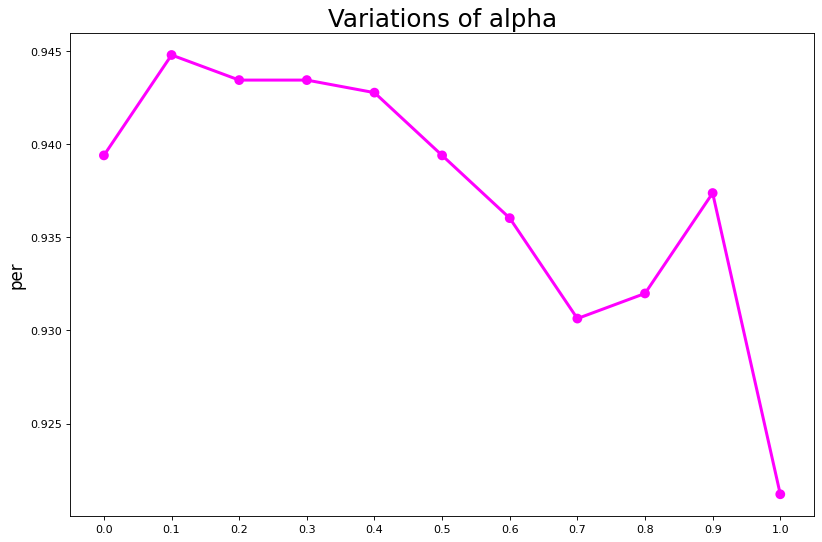

In [171]:
fig, ax = plt.subplots(figsize=(12,8), dpi= 80)    
sns.pointplot(x,y, jitter=0.25, size=8, ax=ax, color="magenta")
plt.title('Variations of alpha', fontsize=22)
plt.ylabel('per', fontsize=15)
plt.show()

Исходя из графика, можно сделать вывод, что лучшее значение параметра == 0.1

### Data visualization

In [ ]:
def creating_plt(binmask):
    driver = gdal.GetDriverByName("Gtiff")
    driver.Register()
    outds = driver.Create("binmask.tiff", binmask.shape[1], binmask.shape[0],  1, gdal.GDT_UInt16)
    geotransform = dataset.GetGeoTransform()
    outds.SetGeoTransform([geotransform[0], geotransform[1], geotransform[2], geotransform[3], geotransform[4], geotransform[5]])
    outds.SetProjection(dataset.GetProjection())
    
    outband = outds.GetRasterBand(1)
    outband.WriteArray(binmask)
    outband.FlushCache()
    outband.SetNoDataValue(np.nan)
    
    outds = None
    
    del binmask, outds
    
    mask_viz = gdal.Open("/Users/the_icecream/Desktop/проект/binmask.tiff", gdal.GA_ReadOnly)
    for x in range(1, mask_viz.RasterCount + 1):
        band = mask_viz.GetRasterBand(x)
        array_mask = band.ReadAsArray()
    return array_mask

In [ ]:
creating_plt(true_mask[0])

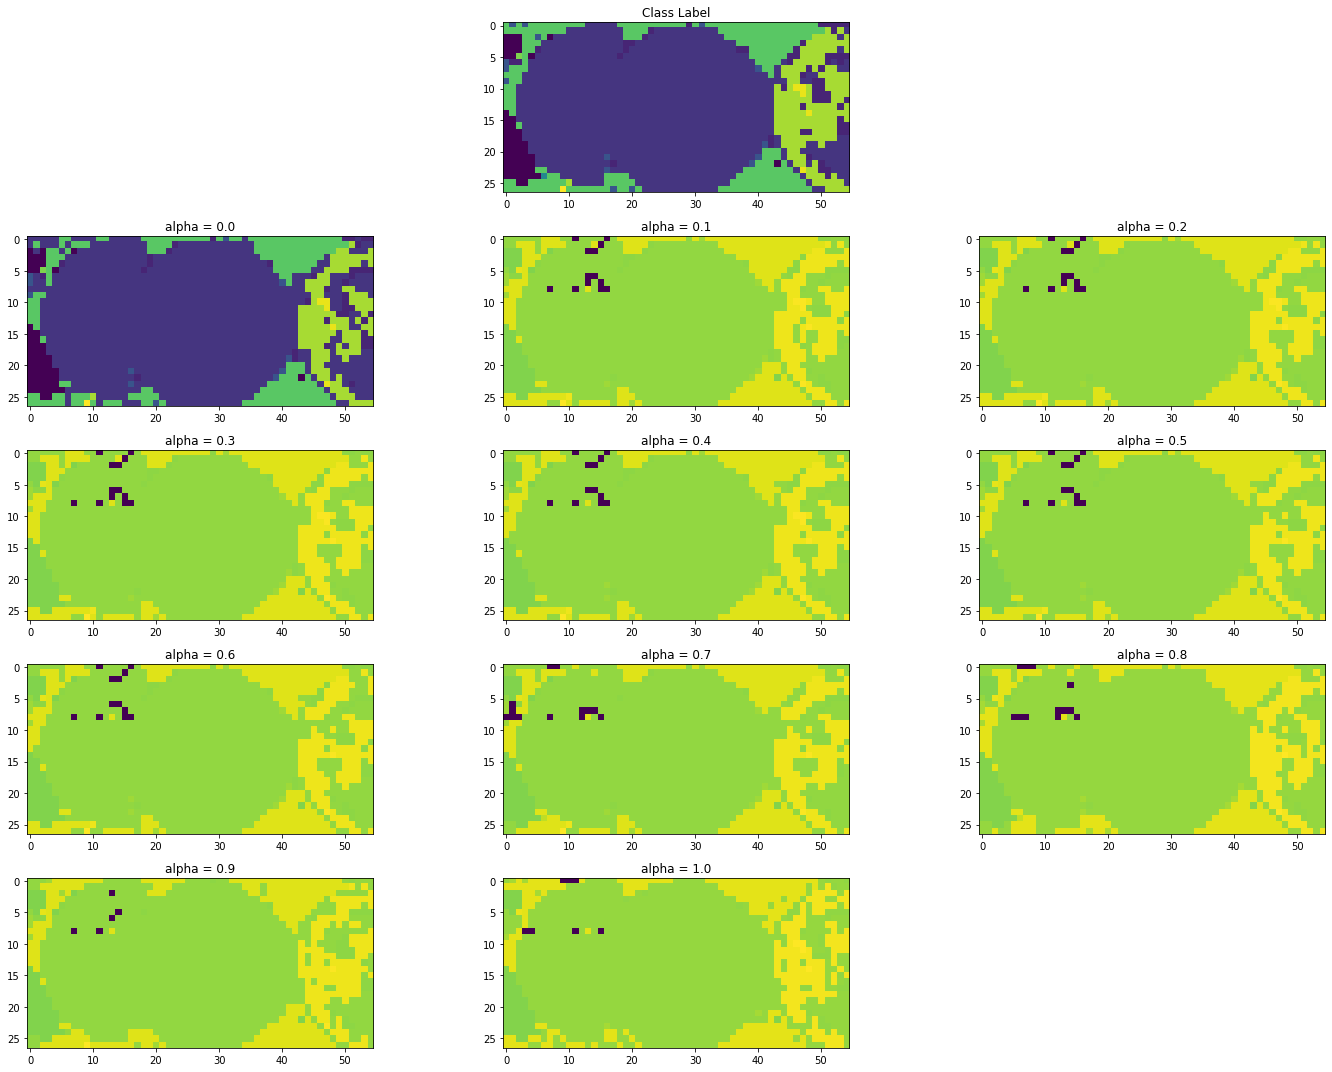

In [210]:
fig, axs = plt.subplots(5, 3, figsize=(20, 15))
axs[0,1].imshow(label0)
axs[0,1].set_title("Class Label")
axs[0,0].remove()
axs[0,2].remove()
for i in range (1,5):
    for j in range(3):
        num = (i-1)*3+j
        if (num == 11):
            axs[i,j].remove()
        else:
            axs[i,j].imshow(true_mask[num])
            axs[i,j].set_title("alpha = "+ str(num/10))
fig.tight_layout()

#### Покажем, какие пиксели были отклассифицированы при всех альфах

In [205]:
x = np.zeros((label0.shape[0], label0.shape[1]), dtype='uint16')
for i in range(label0.shape[0]):
        for j in range(label0.shape[1]):
            if (true_mask[0][i][j]==true_mask[1][i][j]==true_mask[2][i][j]==true_mask[3][i][j]==true_mask[4][i][j]==true_mask[5][i][j]==true_mask[6][i][j]==true_mask[7][i][j]==true_mask[8][i][j]==true_mask[9][i][j]==true_mask[10][i][j]):
                x[i][j] = 1

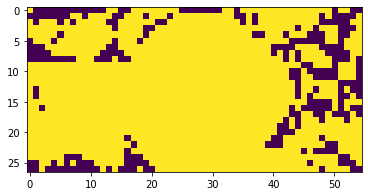

In [206]:
plt.imshow(x) #yellow - the same pixels in all masks